In [40]:
#下一步
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [2]:
import vectorbt as vbt
import pandas as pd
import numpy as np

In [3]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # MacOS自带的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [4]:
# #梳理好因子 ，更具体的，我们是需要OHLCV的数据标准数据才可以用vectorBT去计算量价因子值


# start_date = "2024-09-15"  # 开始日期
# end_date = "2025-04-20"  # 结束日期


# # 首先获取数据并正确构建 DataFrame
# symbols = ["BTC-USD", "SOL-USD", "ETH-USD"]
# data = {}

# for sym in symbols:
#     # 获取每个交易对的数据
#     df = vbt.YFData.download(
#         sym,
#         start=start_date,
#         end=end_date,
#         interval='5m'
#     ).get(['Open', 'High', 'Low', 'Close', 'Volume'])
    
#     # 为每列添加交易对标识
#     df.columns = pd.MultiIndex.from_product([[sym], df.columns])
#     data[sym] = df

# # 合并所有数据
# data = pd.concat(data.values(), axis=1)

# # 现在可以正确提取各个交易对的数据
# btc_data = data.xs('BTC-USD', axis=1, level=0)
# sol_data = data.xs('SOL-USD', axis=1, level=0)
# eth_data = data.xs('ETH-USD', axis=1, level=0)

# # 或者提取所有交易对的特定价格类型
# opens = data.xs('Open', axis=1, level=1)
# highs = data.xs('High', axis=1, level=1)
# lows = data.xs('Low', axis=1, level=1)
# closes = data.xs('Close', axis=1, level=1)
# volumes = data.xs('Volume', axis=1, level=1)

In [5]:
import os

# Set proxy environment variables
os.environ['https_proxy'] = 'http://127.0.0.1:7897'
os.environ['http_proxy'] = 'http://127.0.0.1:7897'
os.environ['all_proxy'] = 'socks5://127.0.0.1:7897'

# ... existing code ...

In [6]:
#用ccxt下载OHLCv数据，并长期数据

import ccxt
import pandas as pd
import time
import os
from datetime import datetime, timedelta
from ccxt.base.errors import NetworkError, RequestTimeout

# 初始化交易所（添加代理设置）
exchange = ccxt.binance({
    'timeout': 30000,  # 设置超时时间为30秒
    'enableRateLimit': True,  # 启用请求频率限制
    'proxies': {
        'http': 'http://127.0.0.1:7897',  # HTTP代理
        'https': 'http://127.0.0.1:7897'  # HTTPS代理
    }
})

# 创建缓存目录
cache_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data_cache')
os.makedirs(cache_dir, exist_ok=True)

def get_cache_filename(symbol, timeframe, start_date, end_date):
    """生成缓存文件名"""
    # 替换符号中的特殊字符
    safe_symbol = symbol.replace('/', '_')
    return os.path.join(cache_dir, f"{safe_symbol}_{timeframe}_{start_date}_{end_date}.csv")

def fetch_historical_ohlcv(symbol, timeframe, start_date, end_date, max_retries=3, use_cache=True):
    """
    分批获取历史OHLCV数据，支持本地缓存
    
    参数:
    symbol (str): 交易对
    timeframe (str): 时间周期
    start_date (str): 开始日期 "YYYY-MM-DD"
    end_date (str): 结束日期 "YYYY-MM-DD"
    max_retries (int): 最大重试次数
    use_cache (bool): 是否使用缓存
    """
    
    cache_file = get_cache_filename(symbol, timeframe, start_date, end_date)
    
    # 检查缓存是否存在
    if use_cache and os.path.exists(cache_file):
        print(f"从缓存加载 {symbol} 数据...")
        try:
            df = pd.read_csv(cache_file)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)
            print(f"成功从缓存加载数据，数据长度: {len(df)}")
            return df
        except Exception as e:
            print(f"读取缓存文件失败: {e}，将重新下载数据")
    
    # 转换日期为时间戳
    start_timestamp = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date + 'T00:00:00Z')
    
    all_ohlcv = []
    current_timestamp = start_timestamp
    
    while current_timestamp < end_timestamp:
        for attempt in range(max_retries):
            try:
                # 获取数据
                ohlcv = exchange.fetch_ohlcv(
                    symbol=symbol,
                    timeframe=timeframe,
                    since=current_timestamp,
                    limit=1000  # 每次获取1000条数据
                )
                
                if not ohlcv:
                    print(f"没有更多数据可获取，当前时间戳: {current_timestamp}")
                    break
                
                all_ohlcv.extend(ohlcv)
                
                # 更新时间戳
                current_timestamp = ohlcv[-1][0] + 1
                
                # 打印进度
                current_date = datetime.fromtimestamp(current_timestamp / 1000)
                print(f"已下载至: {current_date}")
                
                # 添加小延迟以避免触发限制
                time.sleep(0.5)
                break
                
            except (NetworkError, RequestTimeout) as e:
                if attempt == max_retries - 1:
                    print(f"获取数据失败: {e}")
                    raise e
                print(f"尝试 {attempt + 1} 失败，5秒后重试...")
                time.sleep(5)
    
    # 转换为DataFrame
    df = pd.DataFrame(
        all_ohlcv,
        columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
    )
    
    # 将时间戳转换为datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    # 保存到缓存
    if len(df) > 0:
        try:
            df.reset_index().to_csv(cache_file, index=False)
            print(f"数据已缓存到: {cache_file}")
        except Exception as e:
            print(f"缓存数据失败: {e}")
    
    return df

# 使用示例
symbols = ["SOL/USDT"]
timeframe = "5m"
start_date = "2024-08-15"
end_date = "2025-04-20"

# 存储所有数据
data = {}

for symbol in symbols:
    try:
        print(f"\n开始处理 {symbol} 的数据...")
        df = fetch_historical_ohlcv(
            symbol=symbol,
            timeframe=timeframe,
            start_date=start_date,
            end_date=end_date,
            use_cache=True  # 启用缓存
        )
        
        # 为每列添加交易对标识
        df.columns = pd.MultiIndex.from_product([[symbol], df.columns])
        data[symbol] = df
        
        print(f"成功获取 {symbol} 数据，数据长度: {len(df)}")
        print(f"数据时间范围: {df.index.min()} 到 {df.index.max()}")
        
    except Exception as e:
        print(f"处理 {symbol} 数据时出错: {str(e)}")
        continue

# 合并所有数据
if data:
    all_data = pd.concat(data.values(), axis=1)
    print("\n所有数据处理完成！")
    print(f"总数据量: {len(all_data)} 行")
else:
    print("没有成功获取任何数据")


开始处理 SOL/USDT 的数据...
从缓存加载 SOL/USDT 数据...
成功从缓存加载数据，数据长度: 72000
成功获取 SOL/USDT 数据，数据长度: 72000
数据时间范围: 2024-08-15 00:00:00 到 2025-04-21 23:55:00

所有数据处理完成！
总数据量: 72000 行


In [7]:
sol_data = all_data

In [8]:


sol_ohlcv = sol_data.copy()
sol_ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']  # 确保列名正确

# 使用vectorBT绘图
fig = plt.figure(figsize=(15, 8))

# 绘制收盘价
sol_ohlcv['Close'].vbt.plot(title='SOL-USD Price')



FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '2fd7850e-7dde-4112-9411-d93601389939',
              'x': array([datetime.datetime(2024, 8, 15, 0, 0),
                          datetime.datetime(2024, 8, 15, 0, 5),
                          datetime.datetime(2024, 8, 15, 0, 10), ...,
                          datetime.datetime(2025, 4, 21, 23, 45),
                          datetime.datetime(2025, 4, 21, 23, 50),
                          datetime.datetime(2025, 4, 21, 23, 55)], dtype=object),
              'y': array([143.79, 144.1 , 144.12, ..., 136.38, 136.59, 136.56])}],
    'layout': {'height': 350,
               'legend': {'orientation': 'h',
                          'traceorder': 'normal',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'margin': {'b': 30, 'l': 

<Figure size 1500x800 with 0 Axes>

In [9]:
#数据清洗
#去掉异常值
sol_ohlcv.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2024-08-15 00:00:00,143.70,144.03,143.67,143.79,8998.789
2024-08-15 00:05:00,143.79,144.28,143.76,144.10,4812.123
2024-08-15 00:10:00,144.10,144.30,143.88,144.12,7873.042
2024-08-15 00:15:00,144.11,144.19,143.75,144.06,4031.651
2024-08-15 00:20:00,144.06,144.22,143.87,144.19,3394.678


In [10]:
#构造分层训练（分层预处理） TO

#把价格转换为百分比,简单方法：对每个特征计算均值和标准差，应用(x - mean) / std，可用30天滑动窗口适应市场变化。

In [11]:
def calculate_rsi(close: pd.Series, period: int = 9) -> pd.Series:
    """
    计算RSI技术因子
    
    参数:
        close: pd.Series - 收盘价序列
        period: int - RSI计算周期，默认14
        
    返回:
        pd.Series: RSI值序列
    """
    # 计算价格变化
    delta = close.diff()
    
    # 分别获取上涨和下跌的数据
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    
    # 计算平均上涨和下跌
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    # 计算相对强度（RS）
    rs = avg_gain / avg_loss
    
    # 计算RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

#VOL DELTA
def calculate_vol_delta(volume: pd.Series, period: int = 14) -> pd.Series:
    """
    计算成交量差值指标
    参数:
        volume: pd.Series - 成交量序列
        period: int - 计算周期，默认14
    返回:
        pd.Series: VOL DELTA值
    """
    # 计算移动平均
    vol_ma = volume.rolling(window=period).mean()
    
    # 计算当前成交量与移动平均的差值
    vol_delta = (volume - vol_ma) / vol_ma
    
    return vol_delta
    
#BOL
def calculate_bollinger_bands(close: pd.Series, period: int = 20, std_dev: float = 2.0) -> pd.DataFrame:
    """计算布林带指标"""
    middle = close.rolling(window=period).mean()
    std = close.rolling(window=period).std()
    upper = middle + std_dev * std
    lower = middle - std_dev * std
    
    return pd.DataFrame({
        'bb_upper': upper,
        'bb_middle': middle,
        'bb_lower': lower,
        'bb_width': (upper - lower) / middle
    })

#PINBAR
def calculate_pinbar(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    """计算锤子线形态"""
    body = abs(close - close.shift(1))
    upper_shadow = high - close.where(close > close.shift(1), close.shift(1))
    lower_shadow = close.where(close > close.shift(1), close.shift(1)) - low
    return (upper_shadow + lower_shadow) / (body.where(body != 0, 1e-10))

#ATR
def calculate_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    """计算平均真实范围"""
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

#VWAP
def calculate_vwap(close: pd.Series, volume: pd.Series, period: int = 14) -> pd.Series:
    """计算成交量加权平均价格"""
    return (close * volume).rolling(period).sum() / volume.rolling(period).sum()

#MFI
def calculate_mfi(high: pd.Series, low: pd.Series, close: pd.Series, volume: pd.Series, period: int = 14) -> pd.Series:
    """计算资金流量指标"""
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    
    positive_mf = positive_flow.rolling(period).sum()
    negative_mf = negative_flow.rolling(period).sum()
    
    mfi = 100 - (100 / (1 + positive_mf / negative_mf))
    return mfi

#OBV
def calculate_obv(close: pd.Series, volume: pd.Series) -> pd.Series:
    """计算能量潮指标"""
    direction = np.where(close > close.shift(1), 1, np.where(close < close.shift(1), -1, 0))
    return (direction * volume).cumsum()

#CCI
# ... existing code ...

def calculate_cci(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 20) -> pd.Series:
    """计算顺势指标"""
    tp = (high + low + close) / 3
    sma = tp.rolling(window=period).mean()
    # 使用绝对偏差的均值替代mad函数
    mad = tp.rolling(window=period).apply(lambda x: abs(x - x.mean()).mean())
    return (tp - sma) / (0.015 * mad)

# ... existing code ...

#Volume Change Rate
def calculate_volume_change(volume: pd.Series, period: int = 1) -> pd.Series:
    """
    计算成交量变化率
    
    参数:
        volume: pd.Series - 成交量序列
        period: int - 计算周期，默认1
        
    返回:
        pd.Series: 成交量变化率，处理了异常值
    """
    # 处理零值和极小值
    volume_adj = volume.replace(0, np.nan)
    
    # 计算变化率
    vol_change = volume_adj.pct_change(period)
    
    # 处理异常值
    vol_change = vol_change.clip(lower=-0.99, upper=10.0)  # 限制在合理范围内
    
    # 使用前值填充NaN
    vol_change = vol_change.fillna(method='ffill')
    
    return vol_change

# 使用示例
def calculate_all_factors(data: pd.DataFrame) -> pd.DataFrame:
    """计算所有因子"""
    factors = pd.DataFrame({
        'rsi': calculate_rsi(data['Close']),  # 添加RSI因子
        'vol_delta': calculate_vol_delta(data['Volume']),
        'cci': calculate_cci(data['High'], data['Low'], data['Close']),
        'mfi': calculate_mfi(data['High'], data['Low'], data['Close'], data['Volume']),
        'obv': calculate_obv(data['Close'], data['Volume']),
        'atr': calculate_atr(data['High'], data['Low'], data['Close']),
        'vwap': calculate_vwap(data['Close'], data['Volume']),
        'pinbar': calculate_pinbar(data['High'], data['Low'], data['Close']),
        'vol_change': calculate_volume_change(data['Volume'])
    })
    
    # 添加布林带相关指标
    bb_indicators = calculate_bollinger_bands(data['Close'])
    factors = pd.concat([factors, bb_indicators], axis=1)
    
    return factors

# 计算所有因子
all_factors = calculate_all_factors(sol_ohlcv)

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/991178630.py:142: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [12]:
all_factors[-10:]

,rsi,vol_delta,cci,mfi,obv,atr,vwap,pinbar,vol_change,bb_upper,bb_middle,bb_lower,bb_width
timestamp,,,,,,,,,,,,,
2025-04-21 23:10:00,40.495868,0.447480,-136.167998,28.789226,-1.299028e+07,0.269286,135.964232,1.366667,-0.443249,137.028271,136.2890,135.549729,0.010849
2025-04-21 23:15:00,37.391304,0.705047,-86.333534,39.843327,-1.298029e+07,0.267857,135.947356,2.750000,0.272722,136.974963,136.2510,135.527037,0.010627
2025-04-21 23:20:00,34.710744,-0.507720,-82.138986,36.629231,-1.298320e+07,0.264286,135.932679,2.285714,-0.708371,136.950335,136.2200,135.489665,0.010723
2025-04-21 23:25:00,41.481481,-0.365411,-55.584326,43.003344,-1.297957e+07,0.245714,135.923081,1.142857,0.247082,136.839344,136.1770,135.514656,0.009728
2025-04-21 23:30:00,34.838710,-0.118010,-62.263699,40.155109,-1.298472e+07,0.257143,135.902999,1.636364,0.417298,136.688765,136.1195,135.550235,0.008364
2025-04-21 23:35:00,43.971631,-0.449336,-77.165354,39.950494,-1.298149e+07,0.260000,135.895365,2.500000,-0.372568,136.566731,136.0760,135.585269,0.007213
2025-04-21 23:40:00,40.540541,-0.276840,-78.034292,34.691463,-1.298574e+07,0.255714,135.873107,1.888889,0.316914,136.513346,136.0430,135.572654,0.006915
2025-04-21 23:45:00,73.291925,0.373482,46.511628,39.490164,-1.297705e+07,0.288571,135.911982,1.068966,1.042346,136.526161,136.0465,135.566839,0.007051
2025-04-21 23:50:00,78.531073,0.378712,160.496867,45.475209,-1.296781e+07,0.301429,135.964029,1.714286,0.063548,136.561220,136.0535,135.545780,0.007464


In [13]:
#我想知道每个factors的数值范围，等等的信息
def analyze_factors(factors_df: pd.DataFrame):
    """分析因子的详细统计信息"""
    # 创建统计信息表
    stats = pd.DataFrame({
        '最小值': factors_df.min(),
        '25%分位数': factors_df.quantile(0.25),
        '中位数': factors_df.median(),
        '75%分位数': factors_df.quantile(0.75),
        '最大值': factors_df.max(),
        '均值': factors_df.mean(),
        '标准差': factors_df.std(),
        '缺失值比例': factors_df.isnull().mean(),
        '唯一值数量': factors_df.nunique()
    }).round(4)
    
    # 转置以便更好地展示
    stats = stats.T
    
    # 打印统计信息
    print("\n因子统计信息:")
    print(stats.to_string())
    
    return stats

# 使用示例
factor_stats = analyze_factors(all_factors)


因子统计信息:
               rsi   vol_delta         cci         mfi           obv         atr        vwap        pinbar  vol_change    bb_upper   bb_middle    bb_lower    bb_width
最小值         0.0000     -0.9088   -449.1756      0.0000 -1.462602e+07      0.1050     97.2739  8.462000e-01     -0.9456     99.0888     97.7465     95.2299      0.0015
25%分位数     35.7143     -0.3896    -84.6512     36.2804 -2.884414e+06      0.3707    138.3745  1.410300e+00     -0.3120    139.3765    138.4085    137.4226      0.0089
中位数        50.2421     -0.1556      3.1558     49.7549 -5.864504e+05      0.5264    163.0433  2.000000e+00     -0.0219    164.4487    163.1860    161.6205      0.0130
75%分位数     64.6094      0.2123     85.7282     63.0328  1.714270e+06      0.7821    206.2585  3.750000e+00      0.4162    208.2877    206.3035    204.2517      0.0199
最大值       100.0000     10.4610    606.4544    100.0000  5.184466e+06      7.4093    290.8449  3.010000e+10     10.0000    299.9500    288.9595    280.8204  

In [14]:
#标准化检验
def check_factor_standardization(factors_df: pd.DataFrame, 
                               mean_threshold: float = 0.1, 
                               std_threshold: float = 0.2) -> pd.DataFrame:
    """
    检验因子是否满足标准化要求
    """
    results = []
    
    for column in factors_df.columns:
        # 计算基本统计量
        mean = factors_df[column].mean()
        std = factors_df[column].std()
        skew = factors_df[column].skew()
        kurt = factors_df[column].kurtosis()
        
        # 检查是否标准化
        is_standardized = (abs(mean) < mean_threshold) and (abs(1 - std) < std_threshold)
        
        # 格式化数值显示
        results.append({
            '因子名称': column,
            '均值': f"{mean:.4f}" if not np.isinf(mean) and not np.isnan(mean) else "无效值",
            '标准差': f"{std:.4f}" if not np.isinf(std) and not np.isnan(std) else "无效值",
            '偏度': f"{skew:.4f}" if not np.isinf(skew) and not np.isnan(skew) else "无效值",
            '峰度': f"{kurt:.4f}" if not np.isinf(kurt) and not np.isnan(kurt) else "无效值",
            '是否标准化': '是' if is_standardized else '否'
        })
    
    result_df = pd.DataFrame(results)
    
    # 设置pandas显示选项
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    
    # 显示未标准化的因子
    non_standardized = result_df[result_df['是否标准化'] == '否']
    if len(non_standardized) > 0:
        print("\n需要注意的因子:")
        print(non_standardized.to_string(index=False))
    else:
        print("\n所有因子都已经标准化")
    
    return result_df

# 使用示例
standardization_check = check_factor_standardization(all_factors)


需要注意的因子:
      因子名称            均值            标准差      偏度       峰度 是否标准化
       rsi       50.1168        19.8570 -0.0125  -0.5417     否
 vol_delta        0.0225         0.6820  3.1280  18.1258     否
       cci        0.7732       110.7621 -0.0278  -0.4894     否
       mfi       49.6585        18.1351 -0.0130  -0.5808     否
       obv -1855551.1339   4999924.3028 -1.0220  -0.0487     否
       atr        0.6528         0.4706  3.7689  26.7448     否
      vwap      173.3916        41.0162  0.4659  -0.9997     否
    pinbar 44304786.2005 466982010.9183 16.4931 458.6506     否
vol_change        0.2088         0.9425  4.1209  28.4796     否
  bb_upper      174.8707        41.5278  0.4772  -0.9792     否
 bb_middle      173.4041        41.0147  0.4650  -1.0022     否
  bb_lower      171.9374        40.5361  0.4549  -1.0138     否
  bb_width        0.0166         0.0129  4.1604  41.9460     否


In [15]:
#因子值标准化
def standardize_factors(factors_df: pd.DataFrame) -> pd.DataFrame:
    """对不同类型的因子进行针对性标准化"""
    standardized_factors = factors_df.copy()
    
    # 1. RSI类型因子标准化到[-1,1]
     # 1. RSI类型因子标准化到[-1,1]
    # 1. RSI类型因子标准化到[-1,1]
    rsi_type_factors = ['rsi', 'mfi']
    for factor in rsi_type_factors:
        if factor in standardized_factors.columns:
            standardized_factors[factor] = standardized_factors[factor].fillna(50)
            standardized_factors[factor] = standardized_factors[factor].clip(0, 100)
            standardized_factors[factor] = (standardized_factors[factor] - 50) / 50
            # 额外处理：确保均值接近0
            standardized_factors[factor] = standardized_factors[factor] - standardized_factors[factor].mean()
    


    # 2. 布林带相关指标使用z-score标准化
    bb_factors = ['bb_upper', 'bb_middle', 'bb_lower']
    for factor in bb_factors:
        if factor in standardized_factors.columns:
            standardized_factors[factor] = (standardized_factors[factor] - standardized_factors[factor].mean()) / standardized_factors[factor].std()
    
    # 3. 处理异常值较多的因子使用rank标准化
    extreme_factors = ['pinbar', 'cci']
    for factor in extreme_factors:
        if factor in standardized_factors.columns:
            # 先处理无穷大和NaN
            standardized_factors[factor] = standardized_factors[factor].replace([np.inf, -np.inf], np.nan)
            standardized_factors[factor] = standardized_factors[factor].fillna(method='ffill')
            standardized_factors[factor] = standardized_factors[factor].rank(pct=True) * 2 - 1
    
    # 4. 处理量价类因子
    volume_factors = ['obv', 'vwap']
    for factor in volume_factors:
        if factor in standardized_factors.columns:
            standardized_factors[factor] = standardized_factors[factor].fillna(method='ffill').fillna(method='bfill')
            # 使用更稳健的标准化方法
            median = standardized_factors[factor].median()
            mad = (standardized_factors[factor] - median).abs().median()
            standardized_factors[factor] = (standardized_factors[factor] - median) / (mad * 1.4826)
            # 限制极端值并重新标准化
            standardized_factors[factor] = standardized_factors[factor].clip(-3, 3)
            standardized_factors[factor] = (standardized_factors[factor] - standardized_factors[factor].mean()) / standardized_factors[factor].std()
    
    
    # 5. 处理比率类因子
    ratio_factors = ['bb_width', 'atr']
    for factor in ratio_factors:
        if factor in standardized_factors.columns:
            # 先处理异常值
            standardized_factors[factor] = standardized_factors[factor].replace([np.inf, -np.inf], np.nan)
            standardized_factors[factor] = standardized_factors[factor].fillna(method='ffill')
            standardized_factors[factor] = standardized_factors[factor].clip(
                lower=standardized_factors[factor].quantile(0.01),
                upper=standardized_factors[factor].quantile(0.99)
            )
            standardized_factors[factor] = (standardized_factors[factor] - standardized_factors[factor].mean()) / standardized_factors[factor].std()
    
    # 6. 处理变化率类因子
    change_factors = ['vol_delta', 'vol_change']
    for factor in change_factors:
        if factor in standardized_factors.columns:
            standardized_factors[factor] = standardized_factors[factor].replace([np.inf, -np.inf], np.nan)
            standardized_factors[factor] = standardized_factors[factor].fillna(method='ffill')
            # 使用更严格的截断
            standardized_factors[factor] = standardized_factors[factor].clip(
                lower=standardized_factors[factor].quantile(0.05),
                upper=standardized_factors[factor].quantile(0.95)
            )
            standardized_factors[factor] = (standardized_factors[factor] - standardized_factors[factor].mean()) / standardized_factors[factor].std()
    
    return standardized_factors

# 使用示例
standardized_factors = standardize_factors(all_factors)

# 检验标准化效果
print("\n标准化后的因子统计信息:")
analyze_factors(standardized_factors)


标准化后的因子统计信息:

因子统计信息:
              rsi  vol_delta        cci        mfi        obv        atr       vwap     pinbar  vol_change   bb_upper  bb_middle   bb_lower   bb_width
最小值       -1.0023    -1.1983    -1.0000    -0.9932    -1.9624    -1.1239    -1.8558    -1.0000     -1.2096    -1.8248    -1.8446    -1.8923    -1.0972
25%分位数    -0.2879    -0.7396    -0.5000    -0.2675    -0.2568    -0.6695    -0.8536    -0.5000     -0.7349    -0.8547    -0.8532    -0.8515    -0.6632
中位数        0.0025    -0.2716     0.0000     0.0020     0.2371    -0.2871    -0.2527    -0.0002     -0.2620    -0.2510    -0.2491    -0.2545    -0.3018
75%分位数     0.2898     0.4643     0.5000     0.2675     0.7316     0.3409     0.8011     0.5000      0.4522     0.8047     0.8021     0.7972     0.3116
最大值        0.9977     2.5448     1.0000     1.0068     1.4774     4.4444     2.8638     1.0000      2.5613     3.0119     2.8174     2.6861     4.3202
均值        -0.0000     0.0000     0.0000    -0.0000    -0.0000     0.000

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/1283121781.py:32: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/1283121781.py:39: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/1283121781.py:39: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/1283121781.py:55: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/1283121781.py:55: FutureWarning:

Series.fillna with 'method' i

,rsi,vol_delta,cci,mfi,obv,atr,vwap,pinbar,vol_change,bb_upper,bb_middle,bb_lower,bb_width
最小值,-1.0023,-1.1983,-1.0000,-0.9932,-1.9624,-1.1239,-1.8558,-1.0000,-1.2096,-1.8248,-1.8446,-1.8923,-1.0972
25%分位数,-0.2879,-0.7396,-0.5000,-0.2675,-0.2568,-0.6695,-0.8536,-0.5000,-0.7349,-0.8547,-0.8532,-0.8515,-0.6632
中位数,0.0025,-0.2716,0.0000,0.0020,0.2371,-0.2871,-0.2527,-0.0002,-0.2620,-0.2510,-0.2491,-0.2545,-0.3018
75%分位数,0.2898,0.4643,0.5000,0.2675,0.7316,0.3409,0.8011,0.5000,0.4522,0.8047,0.8021,0.7972,0.3116
最大值,0.9977,2.5448,1.0000,1.0068,1.4774,4.4444,2.8638,1.0000,2.5613,3.0119,2.8174,2.6861,4.3202
均值,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000
标准差,0.3971,1.0000,0.5774,0.3627,1.0000,1.0000,1.0000,0.5774,1.0000,1.0000,1.0000,1.0000,1.0000
缺失值比例,0.0000,0.0002,0.0003,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0003,0.0003,0.0003,0.0003
唯一值数量,59045.0000,64789.0000,71977.0000,71955.0000,64064.0000,15891.0000,71987.0000,21780.0000,64801.0000,71821.0000,63860.0000,71821.0000,70372.0000


In [16]:
#标准化检验
def check_factor_standardization(factors_df: pd.DataFrame, 
                               mean_threshold: float = 0.1, 
                               std_threshold: float = 0.2) -> pd.DataFrame:
    """
    检验因子是否满足标准化要求
    """
    results = []
    
    for column in factors_df.columns:
        # 计算基本统计量
        mean = factors_df[column].mean()
        std = factors_df[column].std()
        skew = factors_df[column].skew()
        kurt = factors_df[column].kurtosis()
        
        # 检查是否标准化
        is_standardized = (abs(mean) < mean_threshold) and (abs(1 - std) < std_threshold)
        
        # 格式化数值显示
        results.append({
            '因子名称': column,
            '均值': f"{mean:.4f}" if not np.isinf(mean) and not np.isnan(mean) else "无效值",
            '标准差': f"{std:.4f}" if not np.isinf(std) and not np.isnan(std) else "无效值",
            '偏度': f"{skew:.4f}" if not np.isinf(skew) and not np.isnan(skew) else "无效值",
            '峰度': f"{kurt:.4f}" if not np.isinf(kurt) and not np.isnan(kurt) else "无效值",
            '是否标准化': '是' if is_standardized else '否'
        })
    
    result_df = pd.DataFrame(results)
    
    # 设置pandas显示选项
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    
    # 显示未标准化的因子
    non_standardized = result_df[result_df['是否标准化'] == '否']
    if len(non_standardized) > 0:
        print("\n需要注意的因子:")
        print(non_standardized.to_string(index=False))
    else:
        print("\n所有因子都已经标准化")
    
    return result_df

# 使用示例
standardization_check = check_factor_standardization(standardized_factors)


需要注意的因子:
  因子名称      均值    标准差      偏度      峰度 是否标准化
   rsi -0.0000 0.3971 -0.0125 -0.5414     否
   cci  0.0000 0.5774  0.0000 -1.2000     否
   mfi -0.0000 0.3627 -0.0131 -0.5804     否
pinbar  0.0000 0.5774  0.0000 -1.2000     否


In [17]:
#alpha158

'''
ROC5（变化率，动量因子）
公式：(close / shift(close, 5)) - 1

啥用：看 5 周期（25 分钟）价格涨跌速度，抓短线动量，像 RSI_7 的快版。

为啥推荐：
5 分钟 K 线要快信号，ROC5 比 RSI_14 敏锐，适合日内交易。

加密货币（BTC/ETH）常有急涨急跌，ROC5 能抓突破。

SOL 波动大，ROC5 能适应（短周期信号强）。

整合/替换：
整合：加到 RSI_7/14 旁边，丰富动量信号（RSI 看超买超卖，ROC5 看速度）。

替换：如果 RSI_14 贡献小（LightGBM 特征重要性低），换 ROC5（更快）。

KMID（K 线幅度，价格因子）
公式：(close - open) / open

啥用：看单根 K 线涨跌比例，反映 5 分钟内的趋势强度。

为啥推荐：
加密市场 K 线跳跃大（像 ETH 受事件驱动），KMID 能抓单根大阳/大阴线。

比 VWAP 更直接（VWAP 是全天基准，KMID 是即时信号）。

SOL 高波动，KMID 能捕捉极端走势。

整合/替换：
整合：加到 VWAP、OBV 旁边，补短线价格信号（VWAP 看趋势，KMID 看即时）。

替换：如果 OBV 效果差（累积成交量慢），换 KMID（更即时）。

STD5（标准差，波动因子）
公式：std(close, 5) / close

啥用：看 5 周期（25 分钟）价格波动大小，类似 ATR_5。

为啥推荐：
加密市场波动剧烈（ETH、SOL 常爆拉），STD5 抓短线“抖动”，适合 5 分钟 K 线。

比布林带_10 更快（布林带看区间，STD5 看即时波动）。

LightGBM 爱波动因子（能跟 RSI、Volume Delta 组合）。

整合/替换：
整合：加到 ATR_5/10、布林带旁边，丰富波动信号（ATR 看波幅，STD5 看抖动）。

替换：如果 ATR_10 太慢（特征重要性低），换 STD5（短周期更灵）。

VOLUME5（成交量变化，成交量因子）
公式：volume / mean(volume, 5)

啥用：看当前成交量相对 5 周期均值的放大倍数，类似 Volume Ratio_5。

为啥推荐：
加密货币突破常伴随成交量暴增（BTC 趋势、ETH 事件），VOLUME5 抓资金涌入。

比 Volume Delta 更稳定（Volume Delta 看差值，VOLUME5 看比例）。

SOL 的假成交量多，VOLUME5 用均值滤噪音。

整合/替换：
整合：加到 Volume Delta、Volume Ratio 旁边，补成交量信号（Volume Delta 看差，VOLUME5 看倍数）。

替换：如果 Volume Ratio_10 贡献小，换 VOLUME5（更快更稳）。

VOLT5（成交量波动，成交量因子）
公式：std(volume, 5) / mean(volume, 5)

啥用：看 5 周期成交量抖动大小，反映资金活跃度。

为啥推荐：
加密市场资金流不稳（像 SOL 拉盘），VOLT5 抓成交量异常（比 OBV 敏感）。

补你因子的短板（Volume Delta 看即时，VOLT5 看波动趋势）。

LightGBM 能用 VOLT5 跟 RSI 组合（高 VOLT5 + 高 RSI = 突破）。

整合/替换：
整合：加到 Volume Delta、Volume Ratio，丰富资金流信号。

替换：如果 OBV 效果差（累积慢），换 VOLT5（短线更准）。

CORR5（价格-成交量相关性，相关性因子）
公式：corr(close, volume, 5)

啥用：看 5 周期价格和成交量的联动（正相关 = 量价齐升，负相关 = 背离）。

为啥推荐：
加密市场量价关系关键（BTC 量增价涨常突破），CORR5 抓背离或协同信号。

你因子缺相关性维度，CORR5 补齐（RSI、ATR 看单项，CORR5 看交互）。

SOL 的量价模式乱，CORR5 能滤假信号。

整合/替换：
整合：直接加，补量价联动信号（跟 RSI、Volume Delta 互补）。

替换：如果 MFI_14 效果一般（资金流慢），换 CORR5（更即时）。

RANK5（价格排名，动量因子）
公式：rank(close, 5)，价格在 5 周期里的排名（0 到 1）。

啥用：看价格在短周期里的相对位置（高排名 = 强势）。

为啥推荐：
加密货币趋势强（BTC 牛市、ETH 事件），RANK5 抓短线强势信号。

比 CCI_10 更直观（CCI 复杂，RANK5 简单）。

SOL 高波动，RANK5 能抓顶底。

整合/替换：
整合：加到 RSI、CCI，补动量信号（RSI 看超买，RANK5 看排名）。

替换：如果 CCI_20 贡献低，换 RANK5（更快更简单）。

BETA5（价格回归斜率，趋势因子）
公式：slope(close, 5)，5 周期价格线性回归斜率。

啥用：看短线趋势斜率（正 = 上涨，负 = 下跌）。

为啥推荐：
加密市场趋势明显（BTC 稳涨、SOL 急拉），BETA5 抓趋势加速。

比 VWAP 更动态（VWAP 是基准，BETA5 看斜率）。

LightGBM 爱趋势因子（能跟 Volume Delta 组合）。

整合/替换：
整合：加到 VWAP、OBV，补趋势信号。

替换：如果 OBV 慢，换 BETA5（短线趋势准）。

KURT5（峰度，波动因子）
公式：kurtosis(close, 5)，5 周期价格分布的峰度（高 = 极端波动）。

啥用：看价格是不是老出极端值（高峰度 = 大涨大跌）。

为啥推荐：
加密市场尾部效应强（ETH 事件、SOL meme），KURT5 抓异常波动。

补你波动因子的短板（布林带看区间，KURT5 看极端）。

SOL 波动野，KURT5 能抓大机会。

整合/替换：
整合：加到 ATR、布林带，补极端波动信号。

替换：如果布林带_20 慢，换 KURT5（更敏感）。

SKEW5（偏度，波动因子）
公式：skew(close, 5)，5 周期价格分布的偏度（正 = 偏涨，负 = 偏跌）。

啥用：看价格倾向涨还是跌（正偏度 = 上行概率高）。

为啥推荐：
加密市场不对称（BTC 慢涨急跌，SOL 暴涨暴跌），SKEW5 抓趋势方向。

比 ATR_10 更细（ATR 看波幅，SKEW5 看偏向）。

SOL 的 meme 驱动，SKEW5 能抓单边信号。

整合/替换：
整合：加到 ATR、布林带，补波动方向信号。

替换：如果 ATR_10 贡献小，换 SKEW5（更动态）。


'''

'\nROC5（变化率，动量因子）\n公式：(close / shift(close, 5)) - 1\n\n啥用：看 5 周期（25 分钟）价格涨跌速度，抓短线动量，像 RSI_7 的快版。\n\n为啥推荐：\n5 分钟 K 线要快信号，ROC5 比 RSI_14 敏锐，适合日内交易。\n\n加密货币（BTC/ETH）常有急涨急跌，ROC5 能抓突破。\n\nSOL 波动大，ROC5 能适应（短周期信号强）。\n\n整合/替换：\n整合：加到 RSI_7/14 旁边，丰富动量信号（RSI 看超买超卖，ROC5 看速度）。\n\n替换：如果 RSI_14 贡献小（LightGBM 特征重要性低），换 ROC5（更快）。\n\nKMID（K 线幅度，价格因子）\n公式：(close - open) / open\n\n啥用：看单根 K 线涨跌比例，反映 5 分钟内的趋势强度。\n\n为啥推荐：\n加密市场 K 线跳跃大（像 ETH 受事件驱动），KMID 能抓单根大阳/大阴线。\n\n比 VWAP 更直接（VWAP 是全天基准，KMID 是即时信号）。\n\nSOL 高波动，KMID 能捕捉极端走势。\n\n整合/替换：\n整合：加到 VWAP、OBV 旁边，补短线价格信号（VWAP 看趋势，KMID 看即时）。\n\n替换：如果 OBV 效果差（累积成交量慢），换 KMID（更即时）。\n\nSTD5（标准差，波动因子）\n公式：std(close, 5) / close\n\n啥用：看 5 周期（25 分钟）价格波动大小，类似 ATR_5。\n\n为啥推荐：\n加密市场波动剧烈（ETH、SOL 常爆拉），STD5 抓短线“抖动”，适合 5 分钟 K 线。\n\n比布林带_10 更快（布林带看区间，STD5 看即时波动）。\n\nLightGBM 爱波动因子（能跟 RSI、Volume Delta 组合）。\n\n整合/替换：\n整合：加到 ATR_5/10、布林带旁边，丰富波动信号（ATR 看波幅，STD5 看抖动）。\n\n替换：如果 ATR_10 太慢（特征重要性低），换 STD5（短周期更灵）。\n\nVOLUME5（成交量变化，成交量因子）\n公式：volume / mean(volume, 5)\n\n啥用：看当前成交量相对 5 周期均值的放大倍数，类似

In [18]:
# 动量因子
def roc5(close_series: pd.Series, window: int = 5) -> pd.Series:
    """5周期价格变化率（Rate of Change）"""
    # 实现: (当前close / 5周期前close) - 1
    # 输出: 正值为上涨动量，负值为下跌动量
    return close_series.pct_change(periods=window)

def rank5(close_series: pd.Series, window: int = 5) -> pd.Series:
    """5周期价格排名（0~1标准化）"""
    # 实现: 当前close在5周期窗口内的百分位排名
    # 输出: 1表示周期内最高价，0表示最低价
    return close_series.rolling(window=window).apply(lambda x: stats.percentileofscore(x, x[-1]) / 100, raw=True)

def beta5(close_series: pd.Series, window: int = 5) -> pd.Series:
    """5周期线性回归斜率"""
    # 实现: 用scipy.stats.linregress计算斜率
    # 输出: 正斜率=上涨趋势，负斜率=下跌趋势
    # 注意：linregress 需要至少两个点，所以窗口期至少为2
    if window < 2:
        raise ValueError("Window size must be at least 2 for linear regression.")
    # 使用 apply 应用 linregress
    indices = np.arange(window)
    def get_slope(x):
        # 检查是否有足够的非 NaN 值
        valid_mask = ~np.isnan(x)
        if valid_mask.sum() < 2:
            return np.nan
        slope, _, _, _, _ = stats.linregress(indices[valid_mask], x[valid_mask])
        return slope
    return close_series.rolling(window=window).apply(get_slope, raw=True)

# 波动率因子
def std5(close_series: pd.Series, window: int = 5) -> pd.Series:
    """标准化5周期波动率"""
    # 实现: 5周期标准差 / 当前close（消除量纲影响）
    # 输出: 值越大波动越剧烈
    rolling_std = close_series.rolling(window=window).std()
    return rolling_std / close_series

def kurt5(close_series: pd.Series, window: int = 5) -> pd.Series:
    """5周期价格峰度"""
    # 实现: scipy.stats.kurtosis计算 (Fisher's definition, normal is 0)
    # 输出: 高峰度=出现极端行情的概率高
    return close_series.rolling(window=window).kurt()

def skew5(close_series: pd.Series, window: int = 5) -> pd.Series:
    """5周期价格偏度"""
    # 实现: scipy.stats.skew计算
    # 输出: 正偏=上涨概率高，负偏=下跌概率高
    return close_series.rolling(window=window).skew()

# 成交量因子
def volume5(volume_series: pd.Series, window: int = 5) -> pd.Series:
    """成交量相对5日均值倍数"""
    # 实现: 当前volume / 5周期volume均值
    # 输出: >1表示放量，<1表示缩量
    rolling_mean_volume = volume_series.rolling(window=window).mean()
    # 防止除以零
    rolling_mean_volume = rolling_mean_volume.replace(0, np.nan)
    return volume_series / rolling_mean_volume

def volt5(volume_series: pd.Series, window: int = 5) -> pd.Series:
    """成交量波动率"""
    # 实现: 5周期volume标准差 / 5周期volume均值
    # 输出: 值越大说明资金异动越剧烈
    rolling_std_volume = volume_series.rolling(window=window).std()
    rolling_mean_volume = volume_series.rolling(window=window).mean()
    # 防止除以零
    rolling_mean_volume = rolling_mean_volume.replace(0, np.nan)
    return rolling_std_volume / rolling_mean_volume

def corr5(close_series: pd.Series, volume_series: pd.Series, window: int = 5) -> pd.Series:
    """5周期量价相关性"""
    # 实现: pandas.rolling(窗口).corr(close, volume)
    # 输出: [-1,1]，正相关=量价同向
    return close_series.rolling(window=window).corr(volume_series)


In [19]:
from scipy import stats


In [20]:
close = sol_ohlcv['Close']
volume = sol_ohlcv['Volume']

factors_df = pd.DataFrame({
    'ROC5': roc5(close),
    'RANK5': rank5(close),
    'BETA5': beta5(close),
    'STD5': std5(close),
    'KURT5': kurt5(close),
    'SKEW5': skew5(close),
    'VOLUME5': volume5(volume),
    'VOLT5': volt5(volume),
    'CORR5': corr5(close, volume)
})

In [21]:
factors_df[:30]

,ROC5,RANK5,BETA5,STD5,KURT5,SKEW5,VOLUME5,VOLT5,CORR5
timestamp,,,,,,,,,
2024-08-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-15 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-15 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-15 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-15 00:20:00,NaN,1.0000,0.0760,0.0011,3.3815,-1.7084,0.5831,0.4244,-0.7173
2024-08-15 00:25:00,0.0037,1.0000,0.0510,0.0007,1.1575,1.2117,0.9898,0.3425,-0.0863
2024-08-15 00:30:00,0.0050,1.0000,0.1660,0.0021,3.0303,1.7186,1.4596,0.3946,0.5903
2024-08-15 00:35:00,0.0056,1.0000,0.2370,0.0027,-2.7224,0.4045,0.9252,0.3780,0.6342
2024-08-15 00:40:00,0.0061,1.0000,0.2110,0.0025,-2.8217,-0.6077,1.3830,0.3760,0.6941


In [22]:
#标准化检验
def check_factor_standardization(factors_df: pd.DataFrame, 
                               mean_threshold: float = 0.1, 
                               std_threshold: float = 0.2) -> pd.DataFrame:
    """
    检验因子是否满足标准化要求
    """
    results = []
    
    for column in factors_df.columns:
        # 计算基本统计量
        mean = factors_df[column].mean()
        std = factors_df[column].std()
        skew = factors_df[column].skew()
        kurt = factors_df[column].kurtosis()
        
        # 检查是否标准化
        is_standardized = (abs(mean) < mean_threshold) and (abs(1 - std) < std_threshold)
        
        # 格式化数值显示
        results.append({
            '因子名称': column,
            '均值': f"{mean:.4f}" if not np.isinf(mean) and not np.isnan(mean) else "无效值",
            '标准差': f"{std:.4f}" if not np.isinf(std) and not np.isnan(std) else "无效值",
            '偏度': f"{skew:.4f}" if not np.isinf(skew) and not np.isnan(skew) else "无效值",
            '峰度': f"{kurt:.4f}" if not np.isinf(kurt) and not np.isnan(kurt) else "无效值",
            '是否标准化': '是' if is_standardized else '否'
        })
    
    result_df = pd.DataFrame(results)
    
    # 设置pandas显示选项
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    
    # 显示未标准化的因子
    non_standardized = result_df[result_df['是否标准化'] == '否']
    if len(non_standardized) > 0:
        print("\n需要注意的因子:")
        print(non_standardized.to_string(index=False))
    else:
        print("\n所有因子都已经标准化")
    
    return result_df

# 使用示例
standardization_check = check_factor_standardization(factors_df)


需要注意的因子:
   因子名称      均值    标准差      偏度      峰度 是否标准化
   ROC5  0.0000 0.0063  0.5822 17.2882     否
  RANK5  0.6012 0.3129 -0.0064 -1.5301     否
  BETA5 -0.0001 0.2709  0.2068 19.7943     否
   STD5  0.0022 0.0018  4.2344 42.0058     否
  KURT5 -0.2010 1.9705  0.4041 -0.7652     否
VOLUME5  1.0083 0.4693  1.6019  4.3337     否
  VOLT5  0.4284 0.2190  1.4636  3.4912     否
  CORR5 -0.0147 0.5683  0.0268 -1.2232     否


In [23]:
# 1. 导入必要的库
from scipy.stats import zscore
import numpy as np

# 2. 对因子进行标准化处理
def standardize_factors(factors_df):
    """
    对因子进行标准化处理
    1. 使用中位数填充极端值（MAD方法）
    2. 使用z-score进行标准化
    """
    def mad_winsorize(x, n_std=3):
        """基于MAD方法处理极端值"""
        median = x.median()
        mad = np.abs(x - median).median()
        high = median + n_std * mad
        low = median - n_std * mad
        return np.clip(x, low, high)
    
    # 复制一份数据
    cleaned_factors = factors_df.copy()
    
    # 对每个因子进行处理
    for col in cleaned_factors.columns:
        # 1. 处理极端值
        cleaned_factors[col] = mad_winsorize(cleaned_factors[col])
        # 2. z-score标准化
        cleaned_factors[col] = zscore(cleaned_factors[col], nan_policy='omit')
    
    return cleaned_factors

# 3. 应用标准化
factors_std_df = standardize_factors(factors_df)


In [ ]:
standardization_check = check_factor_standardization(factors_std_df)


所有因子都已经标准化


In [ ]:
# def calculate_trend_probability(close, lookahead=5, smooth_factor=2):
#     """
#     计算趋势概率：
#     1.0: 当前处于上升趋势中
#     0.0: 当前处于下降趋势中
#     0.5: 震荡/盘整
#     """
#     # 计算未来价格变化
#     future_price = close.shift(-lookahead)
#     current_price = close
    
#     # 计算未来lookahead周期内的最高价和最低价
#     future_high = close.rolling(lookahead).max().shift(-lookahead)
#     future_low = close.rolling(lookahead).min().shift(-lookahead)
    
#     # 计算趋势强度
#     up_room = (future_high - current_price) / current_price
#     down_room = (current_price - future_low) / current_price
    
#     # 计算趋势概率
#     trend_strength = (up_room - down_room) / (up_room + down_room + 1e-6)
    
#     # 使用sigmoid函数映射到[0,1]
#     trend_prob = 1 / (1 + np.exp(-smooth_factor * trend_strength))
    
#     # 处理边界情况
#     trend_prob = trend_prob.fillna(0.5)
    
#     return trend_prob


In [ ]:
# def calculate_trend_probability(close, lookback=20, lookahead=5, smooth_factor=3):
#     """
#     改进版趋势概率计算
#     """
#     # 计算未来收益率而不是价格
#     future_return = close.pct_change(periods=lookahead).shift(-lookahead)
    
#     # 使用历史数据计算波动范围
#     historical_returns = close.pct_change(periods=1).rolling(lookback)
#     historical_high = historical_returns.max()
#     historical_low = historical_returns.min()
#     historical_std = historical_returns.std()
    
#     # 计算z-score
#     z_score = future_return / historical_std
    
#     # 使用sigmoid函数转换为概率
#     trend_prob = 1 / (1 + np.exp(-smooth_factor * z_score))
    
#     return trend_prob.fillna(0.5)

# y = calculate_trend_probability(sol_ohlcv['Close'], lookahead=20)

In [120]:
def calculate_future_extremes_return(close: pd.Series, lookahead: int = 5, threshold: float = 0.01) -> pd.Series:
    """
    计算综合预测标签
    
    参数:
        close: 收盘价序列
        lookahead: 预测周期(分钟)
        threshold: 极值识别阈值
    """
    # 计算未来收益率(主要信号)
    future_return = close.shift(-lookahead) / close - 1
    
    # 计算区间最大收益率(辅助信号)
    def rolling_max_return(x):
        return (x.max() - x[0]) / x[0]
    max_return = close.rolling(window=lookahead).apply(rolling_max_return)
    
    # 识别重要价格水平
    def find_levels(x):
        if len(x) < 2:
            return 0
        price_range = (x.max() - x.min()) / x.min()
        if price_range > threshold:
            if x[-1] > x[0]:
                return price_range
            else:
                return -price_range
        return 0
    
    level_signal = close.rolling(window=lookahead).apply(find_levels)
    
    # 综合多个信号
    combined_signal = (
        0.5 * future_return +  # 未来收益权重
        0.3 * max_return +     # 最大收益权重
        0.2 * level_signal     # 价格水平权重
    )
    
    return combined_signal
# 提高阈值到2%以筛选更显著的机会
# y = calculate_future_extremes_return(close, threshold=0.02)
y = calculate_future_extremes_return(close)

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/2853080317.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/hr/b0cfzgc12x14gx406z0dh9h80000gn/T/ipykernel_90707/2853080317.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [121]:
y[50:100]

timestamp
2024-08-15 04:10:00   -0.0001
2024-08-15 04:15:00   -0.0007
2024-08-15 04:20:00   -0.0002
2024-08-15 04:25:00    0.0013
2024-08-15 04:30:00    0.0020
2024-08-15 04:35:00    0.0015
2024-08-15 04:40:00    0.0012
2024-08-15 04:45:00    0.0000
2024-08-15 04:50:00   -0.0018
2024-08-15 04:55:00    0.0003
2024-08-15 05:00:00    0.0012
2024-08-15 05:05:00    0.0026
2024-08-15 05:10:00    0.0015
2024-08-15 05:15:00    0.0011
2024-08-15 05:20:00   -0.0023
2024-08-15 05:25:00   -0.0020
2024-08-15 05:30:00   -0.0048
2024-08-15 05:35:00   -0.0027
2024-08-15 05:40:00   -0.0039
2024-08-15 05:45:00   -0.0019
2024-08-15 05:50:00   -0.0046
2024-08-15 05:55:00   -0.0064
2024-08-15 06:00:00   -0.0044
2024-08-15 06:05:00   -0.0037
2024-08-15 06:10:00   -0.0044
2024-08-15 06:15:00   -0.0011
2024-08-15 06:20:00   -0.0035
2024-08-15 06:25:00   -0.0011
2024-08-15 06:30:00    0.0008
2024-08-15 06:35:00    0.0008
2024-08-15 06:40:00    0.0003
2024-08-15 06:45:00    0.0031
2024-08-15 06:50:00    0.0017


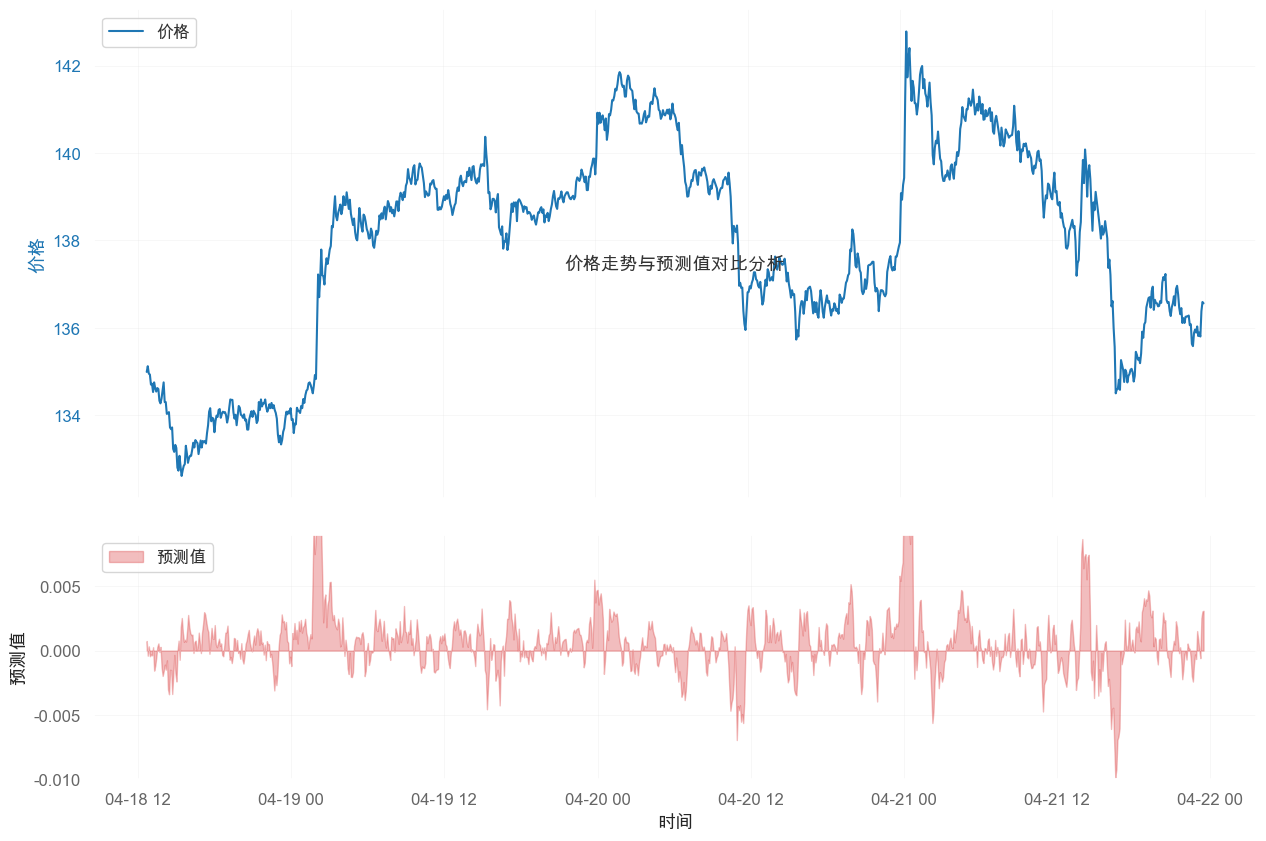

In [162]:
def plot_price_and_prediction(close: pd.Series, y: pd.Series, window: int = 1000):
    """可视化价格和预测值"""
    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)  # 减小子图间距
    
    # 上图：价格走势
    ax1.plot(close[-window:], color='tab:blue', label='价格')
    ax1.set_ylabel('价格', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # 下图：预测值
    ax2.fill_between(y[-window:].index, y[-window:], color='tab:red', alpha=0.3, label='预测值')
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)  # 添加0.5参考线
    ax2.set_ylim(-0.01, 0.009)
    ax2.set_ylabel('预测值')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')
    
    # 设置x轴标签只在底部显示
    ax1.set_xticklabels([])
    ax2.set_xlabel('时间')
    
    plt.title('价格走势与预测值对比分析', y=2.05)
    plt.show()
# 使用示例
plot_price_and_prediction(sol_ohlcv['Close'], y)

In [123]:
# 先创建一个新的DataFrame只包含OHLCV数据
sol_data_clean = sol_ohlcv[['Open', 'High', 'Low', 'Close', 'Volume']]

# 合并数据，确保每个列只出现一次
sol_ohlcv = pd.concat([
    sol_data_clean,  # 原始OHLCV数据
    standardized_factors,      # 原始因子数据
    factors_std_df,  # 标准化后的因子数据
    pd.Series(y, name='y')  # 预测目标值
], axis=1)

# # 为了避免列名冲突，给标准化后的因子添加前缀
# factors_std_df_renamed = factors_std_df.add_prefix('std_')
# sol_data = pd.concat([
#     sol_data_clean,  # 原始OHLCV数据
#     standardized_factors,      # 原始因子数据
#     factors_std_df_renamed,  # 标准化后的因子（带前缀）
#     pd.Series(y, name='y')  # 预测目标值
# ], axis=1)

# 检查结果
print("合并后的数据信息：")
print("列名:", sol_ohlcv.columns.tolist())
print("\n数据形状:", sol_ohlcv.shape)

合并后的数据信息：
列名: ['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'vol_delta', 'cci', 'mfi', 'obv', 'atr', 'vwap', 'pinbar', 'vol_change', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_width', 'ROC5', 'RANK5', 'BETA5', 'STD5', 'KURT5', 'SKEW5', 'VOLUME5', 'VOLT5', 'CORR5', 'y']

数据形状: (72000, 28)


In [124]:


# 1. 准备特征和标签
def prepare_training_data(data, feature_cols, target_col='y', test_size=0.2):
    """准备训练数据"""
    # 删除包含NaN的行
    valid_data = data.dropna()
    
    # 分割特征和标签
    X = valid_data[feature_cols]
    y = valid_data[target_col]
    
    # 时间序列分割
    split_idx = int(len(valid_data) * (1 - test_size))
    
    X_train = X.iloc[:split_idx]
    y_train = y.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]
    
    return X_train, X_test, y_train, y_test


In [125]:

# 2. 定义LightGBM参数
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# 3. 准备训练数据
feature_cols = [col for col in sol_ohlcv.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'y']]
X_train, X_test, y_train, y_test = prepare_training_data(sol_ohlcv, feature_cols)

# 4. 创建数据集
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 5. 训练模型
# 5. 训练模型
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Use early_stopping callback
        lgb.log_evaluation(period=100)           # Log evaluation metrics every 100 iterations
    ]
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.00352461


In [126]:
print(f"训练集: {X_train.shape}, 验证集: {X_test.shape}")


训练集: (57580, 22), 验证集: (14396, 22)


In [179]:
# 6. 预测和评估
y_pred = model.predict(X_test)

# 7. 特征重要性分析
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance('gain')
})
importance = importance.sort_values('importance', ascending=False)

print("\n特征重要性排序:")
print(importance)




特征重要性排序:
       feature  importance
15       BETA5      0.9474
16        STD5      0.2450
11    bb_lower      0.1335
12    bb_width      0.1201
2          cci      0.0643
5          atr      0.0608
4          obv      0.0428
13        ROC5      0.0373
3          mfi      0.0332
9     bb_upper      0.0303
1    vol_delta      0.0257
10   bb_middle      0.0192
21       CORR5      0.0188
0          rsi      0.0174
20       VOLT5      0.0149
6         vwap      0.0107
7       pinbar      0.0082
17       KURT5      0.0082
14       RANK5      0.0056
18       SKEW5      0.0047
8   vol_change      0.0031
19     VOLUME5      0.0028


In [ ]:
def filter_signals(signals, min_holding_period=3):
    """
    过滤频繁交易信号
    """
    filtered_signals = signals.copy()
    last_signal = 0
    holding_period = 0
    
    for i in range(len(signals)):
        if signals[i] != last_signal:
            if holding_period < min_holding_period:
                filtered_signals[i] = last_signal
            else:
                last_signal = signals[i]
                holding_period = 0
        holding_period += 1
    
    return filtered_signals


预测结果统计:
实际值均值: 0.0008
预测值均值: 0.0009
实际值标准差: 0.0039
预测值标准差: 0.0017

评估指标:
MSE: 0.0000
R²: 0.1981


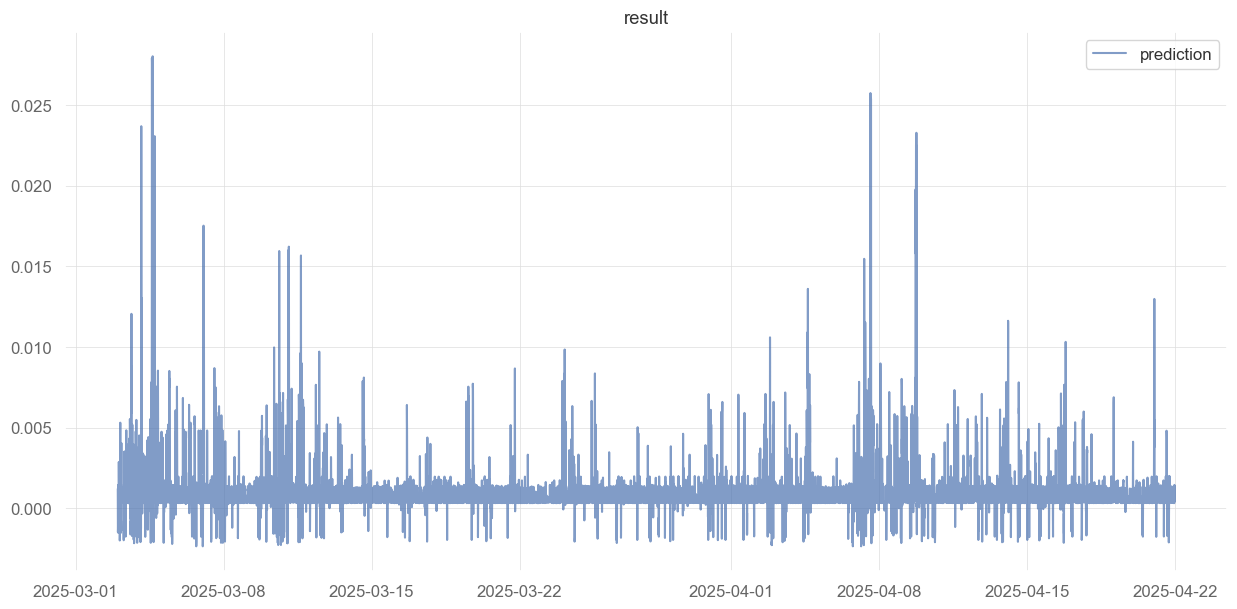

In [128]:
# ... existing code ...

# 打印预测结果统计信息
print("\n预测结果统计:")
print(f"实际值均值: {y_test.mean():.4f}")
print(f"预测值均值: {y_pred.mean():.4f}")
print(f"实际值标准差: {y_test.std():.4f}") 
print(f"预测值标准差: {y_pred.std():.4f}")

# 计算并打印评估指标
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n评估指标:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# 8. 绘制预测结果
plt.figure(figsize=(15, 7))
# plt.plot(y_test.index, y_test.values, label='acutully', alpha=0.7)
plt.plot(y_test.index, y_pred, label='prediction', alpha=0.7)
plt.title('result')
plt.legend()
plt.grid(True)
plt.show()

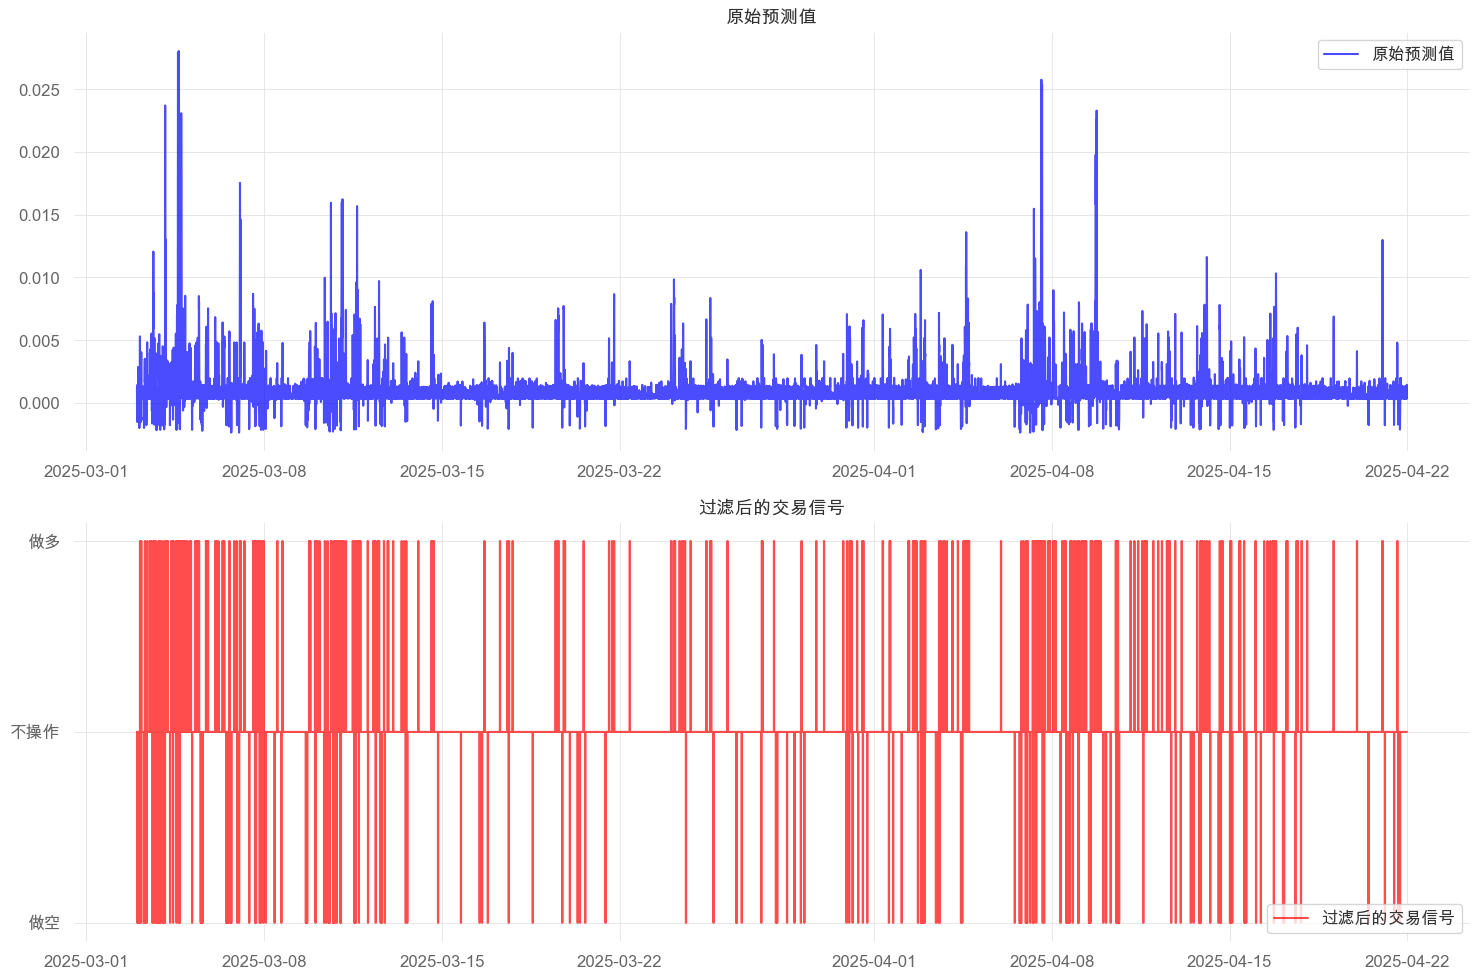


交易信号分布:
做多信号数量: 1033
中性信号数量: 12782
做空信号数量: 581


In [ ]:
# # ... existing code ...

# # 1. 首先将预测值转换为交易信号
# def zscore_based_signal(predictions, z_threshold=1.0):
#     """基于Z-Score的信号转换"""
#     z_scores = (predictions - predictions.mean()) / predictions.std()
#     signals = np.zeros_like(predictions)
#     signals[z_scores > z_threshold] = 1
#     signals[z_scores < -z_threshold] = -1
#     return signals

# # 2. 过滤频繁交易信号
# def filter_signals(signals, min_holding_period=3):
#     """过滤频繁交易信号"""
#     filtered_signals = signals.copy()
#     last_signal = 0
#     holding_period = 0
    
#     for i in range(len(signals)):
#         if signals[i] != last_signal:
#             if holding_period < min_holding_period:
#                 filtered_signals[i] = last_signal
#             else:
#                 last_signal = signals[i]
#                 holding_period = 0
#         holding_period += 1
    
#     return filtered_signals

# # 3. 生成信号并过滤
# raw_signals = zscore_based_signal(y_pred, z_threshold=1.0)
# filtered_signals = filter_signals(raw_signals, min_holding_period=3)

# # 4. 创建一个包含两个子图的图表
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# # 绘制原始预测值
# ax1.plot(y_test.index, y_pred, label='原始预测值', alpha=0.7, color='blue')
# ax1.set_title('原始预测值')
# ax1.grid(True)
# ax1.legend()

# # 绘制过滤后的交易信号
# ax2.plot(y_test.index, filtered_signals, label='过滤后的交易信号', 
#          drawstyle='steps-post', color='red', alpha=0.7)
# ax2.set_title('过滤后的交易信号')
# ax2.grid(True)
# ax2.set_yticks([-1, 0, 1])
# ax2.set_yticklabels(['做空', '不操作', '做多'])
# ax2.legend()

# # 调整子图间距
# plt.tight_layout()

# # 显示图表
# plt.show()

# # 打印信号统计信息
# signal_distribution = pd.Series(filtered_signals).value_counts()
# print("\n交易信号分布:")
# print(f"做多信号数量: {signal_distribution.get(1, 0)}")
# print(f"中性信号数量: {signal_distribution.get(0, 0)}")
# print(f"做空信号数量: {signal_distribution.get(-1, 0)}")

In [168]:
def generate_probability_signals(predictions, window=20):
    """
    使用滚动标准差和概率分布来生成交易信号
    
    参数:
    predictions: 模型预测值
    window: 滚动窗口大小
    """
    # 计算滚动均值和标准差
    rolling_mean = predictions.rolling(window=window).mean()
    rolling_std = predictions.rolling(window=window).std()
    
    # 计算z-score，但使用滚动统计量
    z_scores = (predictions - rolling_mean) / rolling_std
    
    # 计算预测值在当前窗口内的百分位数
    rolling_percentile = predictions.rolling(window=window).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    
    # 直接返回百分位数作为信号
    # 不再使用z-score相乘，因为这可能导致信号失真
    smoothed_score = rolling_percentile.ewm(span=window//2).mean()
    
    return smoothed_score

def filter_signals_with_probability(scores, buy_threshold=0.8, sell_threshold=0.2, min_interval=12):
    """
    基于概率分数生成交易信号，保证单一持仓
    高概率买入（预期上涨），低概率卖出（预期下跌）
    
    参数:
    scores: 概率得分
    buy_threshold: 买入阈值（高于此值买入）
    sell_threshold: 卖出阈值（低于此值卖出）
    min_interval: 最小信号间隔（以5分钟K线为单位）
    """
    signals = pd.Series(index=scores.index, data=0)
    last_signal_idx = None
    in_position = False
    
    for idx in scores.index:
        if not in_position:  # 当前没有持仓
            # 在高概率时买入（预期上涨）
            current_rank = pd.Series(scores.loc[:idx]).rank(pct=True).iloc[-1]
            if current_rank > buy_threshold:  # 只有在高概率时买入
                if last_signal_idx is None or (idx - last_signal_idx).total_seconds() / 300 >= min_interval:
                    signals[idx] = 1
                    last_signal_idx = idx
                    in_position = True
        else:  # 当前持有仓位
            # 在低概率时卖出（预期下跌）
            current_rank = pd.Series(scores.loc[:idx]).rank(pct=True).iloc[-1]
            if current_rank < sell_threshold:  # 只有在低概率时卖出
                if (idx - last_signal_idx).total_seconds() / 300 >= min_interval:
                    signals[idx] = -1
                    last_signal_idx = idx
                    in_position = False
                
    return signals

# 生成交易信号
filtered_signals = filter_signals_with_probability(
    probability_scores,
    buy_threshold=0.85,    # 在排名前15%时买入（高概率上涨）
    sell_threshold=0.15,   # 在排名后15%时卖出（高概率下跌）
    min_interval=12
)


# ... existing code ...

# 获取买卖信号点
buy_signals = filtered_signals[filtered_signals == 1].index
sell_signals = filtered_signals[filtered_signals == -1].index

# 打印信号统计信息
print("\n交易信号统计:")
print(f"买入信号数量: {len(buy_signals)}")
print(f"卖出信号数量: {len(sell_signals)}")


交易信号统计:
买入信号数量: 53
卖出信号数量: 53



Z-Score统计信息:
Z-Score最大值: 10.6913
Z-Score最小值: -2.6083
Z-Score均值: -0.0000
Z-Score标准差: 1.0000


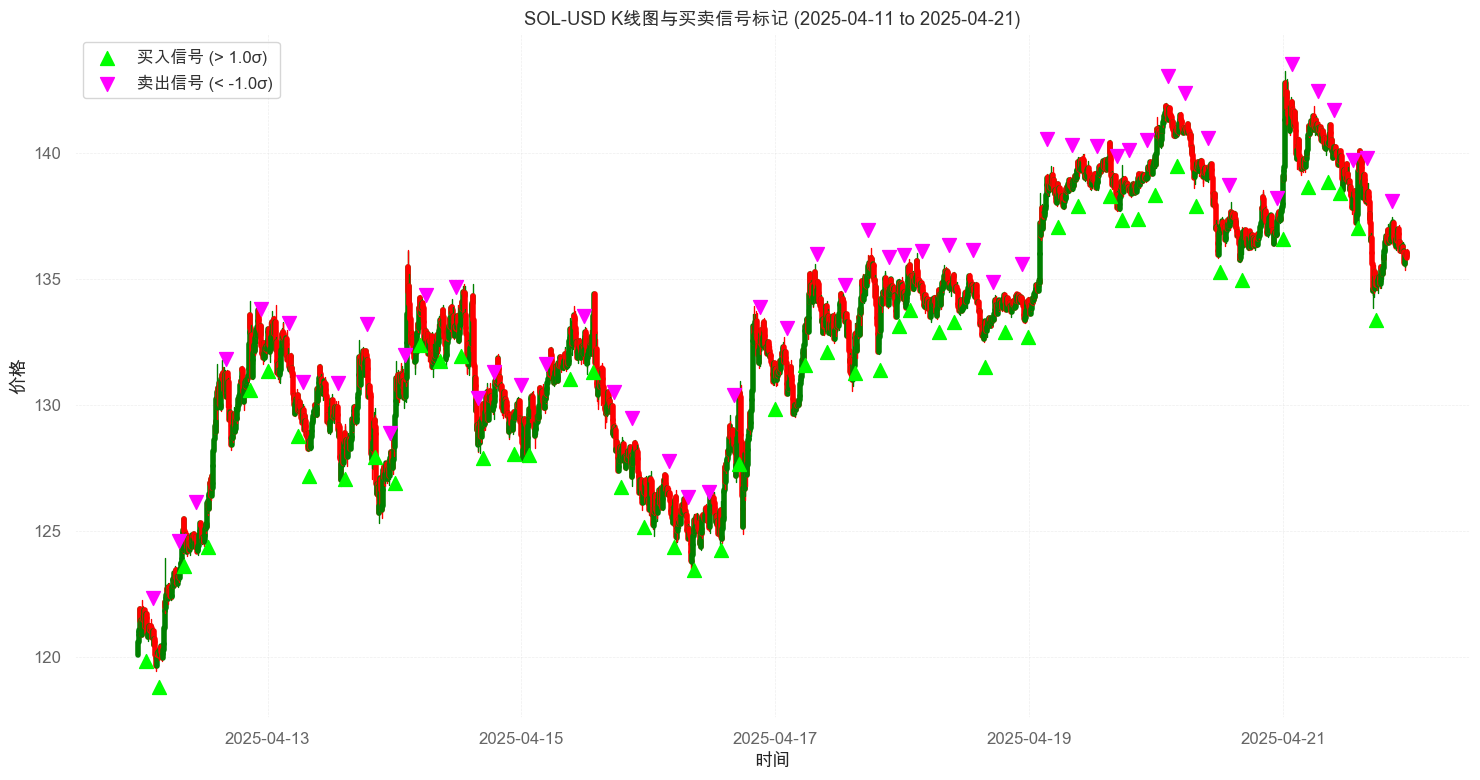

In [169]:


# 打印一下z_scores的统计信息，看看分布情况
print("\nZ-Score统计信息:")
print(f"Z-Score最大值: {z_scores.max():.4f}")
print(f"Z-Score最小值: {z_scores.min():.4f}")
print(f"Z-Score均值: {z_scores.mean():.4f}")
print(f"Z-Score标准差: {z_scores.std():.4f}")


# 5. 创建K线图
plt.figure(figsize=(15, 8))

# 确保 plot_data 包含绘图所需列
plot_kline = plot_data[['Open', 'High', 'Low', 'Close']]

# 绘制K线主体
for idx, row in plot_kline.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'
    # 绘制影线
    plt.plot([idx, idx], [row['Low'], row['High']], color=color, linewidth=1)
    # 绘制实体
    plt.plot([idx, idx], [row['Open'], row['Close']], color=color, linewidth=4)

# 标记买卖点
buy_scatter = plt.scatter([], [], 
                        color='lime', marker='^', s=100,
                        label=f'买入信号 (> {threshold}σ)')

sell_scatter = plt.scatter([], [], 
                         color='magenta', marker='v', s=100,
                         label=f'卖出信号 (< -{threshold}σ)')

# 如果有信号点，再绘制实际的信号点
if len(buy_signals) > 0:
    plt.scatter(buy_signals,
               plot_kline.loc[buy_signals, 'Low'] * 0.99,
               color='lime', marker='^', s=100, zorder=5)

if len(sell_signals) > 0:
    plt.scatter(sell_signals,
               plot_kline.loc[sell_signals, 'High'] * 1.01,
               color='magenta', marker='v', s=100, zorder=5)

# 设置图表属性
plt.title(f'SOL-USD K线图与买卖信号标记 ({start_date_plot.date()} to {end_date_plot.date()})')
plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


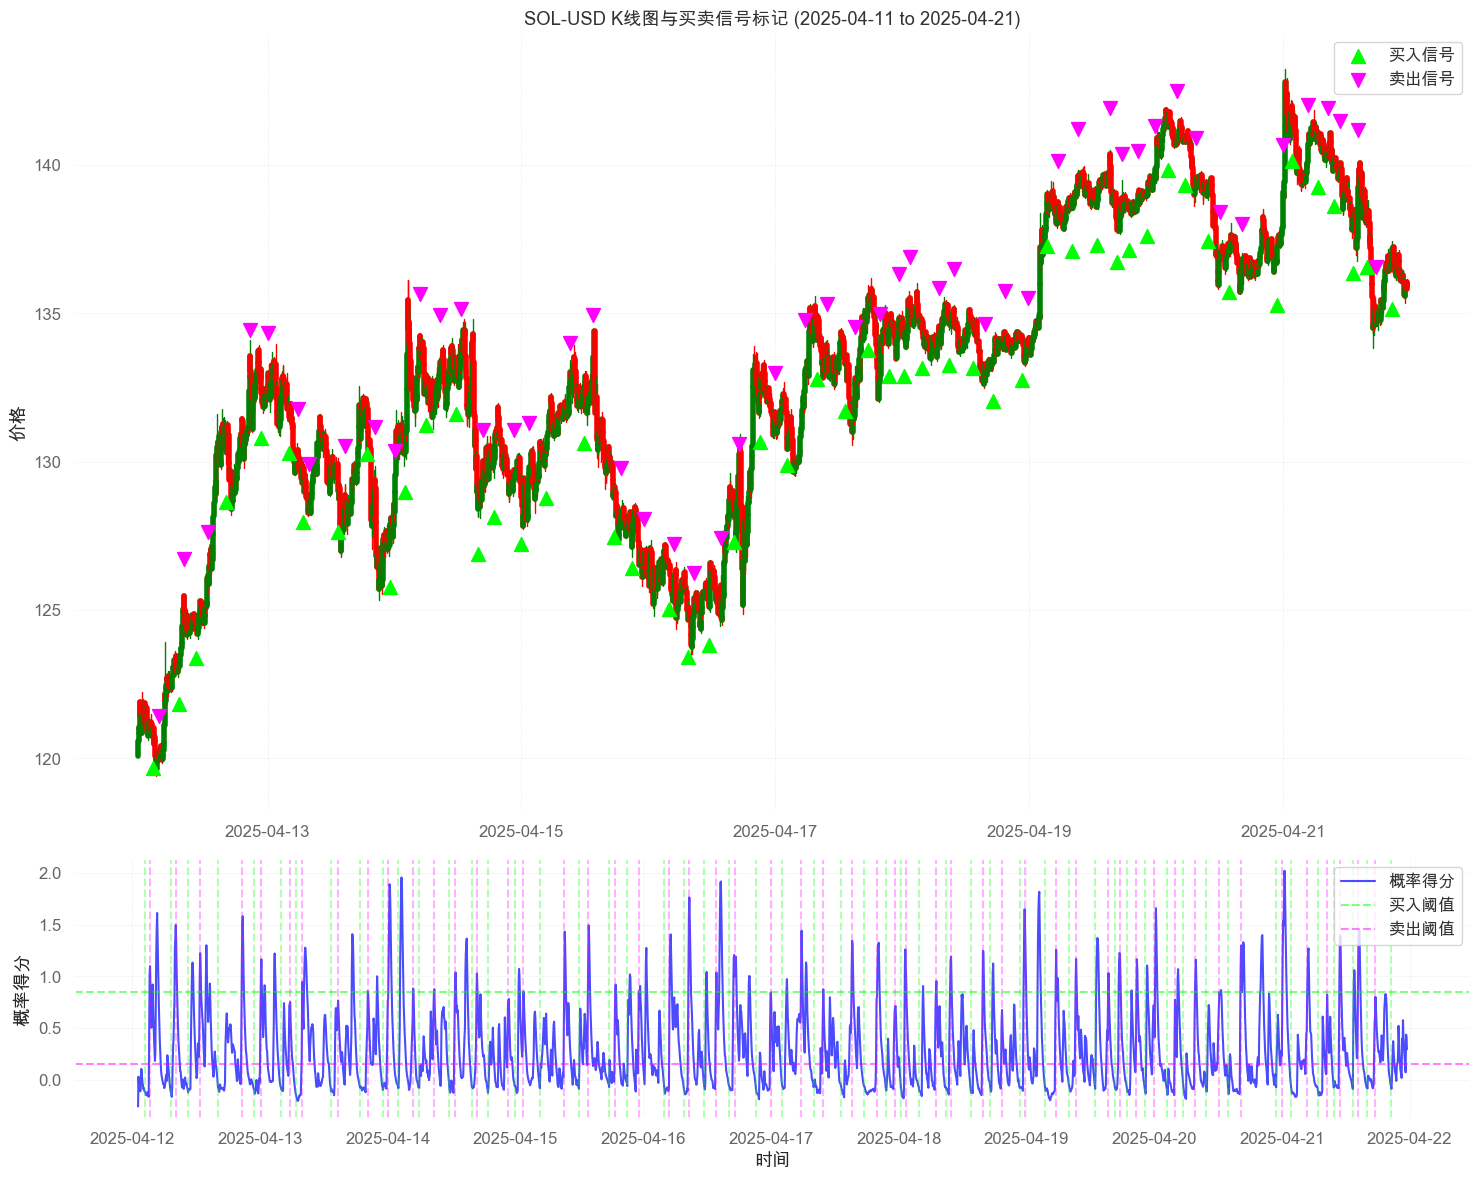


交易信号统计:
买入信号数量: 53
卖出信号数量: 52
信号间隔平均值: 270.19分钟


In [164]:
# 创建子图，上面显示K线和信号，下面显示概率得分
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [3, 1]})

# 绘制K线图（上图）
for idx, row in plot_kline.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'
    # 绘制影线
    ax1.plot([idx, idx], [row['Low'], row['High']], color=color, linewidth=1)
    # 绘制实体
    ax1.plot([idx, idx], [row['Open'], row['Close']], color=color, linewidth=4)

# 标记买卖点
buy_scatter = ax1.scatter([], [], 
                       color='lime', marker='^', s=100,
                       label='买入信号')

sell_scatter = ax1.scatter([], [], 
                        color='magenta', marker='v', s=100,
                        label='卖出信号')

# 绘制实际的信号点
if len(buy_signals) > 0:
    ax1.scatter(buy_signals,
              plot_kline.loc[buy_signals, 'Low'] * 0.99,
              color='lime', marker='^', s=100, zorder=5)

if len(sell_signals) > 0:
    ax1.scatter(sell_signals,
              plot_kline.loc[sell_signals, 'High'] * 1.01,
              color='magenta', marker='v', s=100, zorder=5)

# 设置上图属性
ax1.set_title(f'SOL-USD K线图与买卖信号标记 ({start_date_plot.date()} to {end_date_plot.date()})')
ax1.set_ylabel('价格')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# 绘制概率得分（下图）
ax2.plot(probability_scores.index, probability_scores.values, 
         color='blue', alpha=0.7, label='概率得分')

# 添加买卖信号的垂直线
for idx in buy_signals:
    ax2.axvline(x=idx, color='lime', alpha=0.3, linestyle='--')
for idx in sell_signals:
    ax2.axvline(x=idx, color='magenta', alpha=0.3, linestyle='--')

# 添加阈值线
ax2.axhline(y=0.85, color='lime', linestyle='--', alpha=0.5, label='买入阈值')
ax2.axhline(y=0.15, color='magenta', linestyle='--', alpha=0.5, label='卖出阈值')

# 设置下图属性
ax2.set_xlabel('时间')
ax2.set_ylabel('概率得分')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

# 调整布局
plt.tight_layout()
plt.show()

# 打印交易统计信息
print("\n交易信号统计:")
print(f"买入信号数量: {len(buy_signals)}")
print(f"卖出信号数量: {len(sell_signals)}")
print(f"信号间隔平均值: {np.mean([buy_signals[i+1] - buy_signals[i] for i in range(len(buy_signals)-1)]).total_seconds()/60:.2f}分钟")

In [175]:
# ... existing code ...

# 假设 sol_ohlcv, y_test, y_pred 已经定义

# 1. 确定要绘制的最近一个月的时间范围（基于测试集 y_test 的时间）
if not y_test.empty:
    end_date_plot = y_test.index.max()
    start_date_plot = end_date_plot - pd.Timedelta(days=10)  # 近似一个月

    # 2. 筛选出最近一个月用于绘图的K线数据
    plot_data = sol_ohlcv.loc[start_date_plot:end_date_plot].copy()

    # 3. 筛选出对应时间段的 y_test 和 y_pred
    # 确保 y_pred 是与 y_test 索引对齐的 numpy 数组或 pandas Series
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    
    # 修改：使用索引的交集来确保数据对齐
    common_index = plot_data.index.intersection(y_test.index)
    filtered_y_test = y_test.loc[common_index]
    filtered_y_pred = y_pred_series.loc[common_index]
    plot_data = plot_data.loc[common_index]

    # 4. 基于筛选后的数据重新计算买卖信号
    # 4. 基于筛选后的数据重新计算买卖信号
    # 使用标准差作为阈值（比如1个标准差）
#     threshold = 1.0  # 可以根据需要调整，1.0表示1个标准差
#     sell_signals = filtered_y_test[filtered_y_pred < -threshold]  # 卖出信号阈值
#     buy_signals = filtered_y_test[filtered_y_pred > threshold]    # 买入信号阈值

#    # ... existing code ...

#     # 5. 创建K线图
#     plt.figure(figsize=(15, 8))

#     # 确保 plot_data 包含绘图所需列
#     plot_kline = plot_data[['Open', 'High', 'Low', 'Close']]

#     # 绘制K线主体
#     for idx, row in plot_kline.iterrows():
#         color = 'green' if row['Close'] >= row['Open'] else 'red'
#         # 绘制影线
#         plt.plot([idx, idx], [row['Low'], row['High']], color=color, linewidth=1)
#         # 绘制实体
#         plt.plot([idx, idx], [row['Open'], row['Close']], color=color, linewidth=4)

#     # 标记买卖点 (修改后的代码)
#     # 即使没有信号也创建图例项
#     buy_scatter = plt.scatter([], [], 
#                             color='lime', marker='^', s=100,
#                             label=f'买入信号 (> {threshold}σ)')
    
#     sell_scatter = plt.scatter([], [], 
#                              color='magenta', marker='v', s=100,
#                              label=f'卖出信号 (< -{threshold}σ)')
    
#     # 如果有信号点，再绘制实际的信号点
#     if not buy_signals.empty:
#         plt.scatter(buy_signals.index,
#                    plot_kline.loc[buy_signals.index, 'Low'] * 0.99,
#                    color='lime', marker='^', s=100, zorder=5)
    
#     if not sell_signals.empty:
#         plt.scatter(sell_signals.index,
#                    plot_kline.loc[sell_signals.index, 'High'] * 1.01,
#                    color='magenta', marker='v', s=100, zorder=5)

#     # 设置图表属性
#     plt.title(f'SOL-USD K线图与买卖信号标记 ({start_date_plot.date()} to {end_date_plot.date()})')
#     plt.xlabel('时间')
#     plt.ylabel('价格')
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.5)
#     plt.tight_layout()
#     plt.show()

# # ... existing code ...

# else:
#     print("y_test 数据为空，无法生成图表。")

# # ... existing code ...

In [176]:
# ... existing code ...

def filter_signals_single_position(z_scores, threshold, min_interval=12):
    """
    生成交易信号，保证同一时间只有一个持仓
    
    参数:
    z_scores: 标准化后的预测值
    threshold: 信号阈值
    min_interval: 最小信号间隔（默认12个5分钟K线）
    
    返回:
    signals: 包含交易信号的Series (1:买入, -1:卖出, 0:不操作)
    """
    signals = pd.Series(index=z_scores.index, data=0)
    last_signal_idx = None
    in_position = False  # 跟踪当前是否持仓
    
    for idx in z_scores.index:
        if not in_position:  # 当前没有持仓
            if z_scores[idx] > threshold:  # 满足买入条件
                if last_signal_idx is None or (idx - last_signal_idx).total_seconds() / 300 >= min_interval:
                    signals[idx] = 1  # 买入信号
                    last_signal_idx = idx
                    in_position = True  # 标记为已持仓
        else:  # 当前持有仓位
            if z_scores[idx] < -threshold:  # 满足卖出条件
                if (idx - last_signal_idx).total_seconds() / 300 >= min_interval:
                    signals[idx] = -1  # 卖出信号
                    last_signal_idx = idx
                    in_position = False  # 标记为未持仓
                
    return signals

# 使用新的信号生成函数
# 先对预测值进行标准化
z_scores = (filtered_y_pred - filtered_y_pred.mean()) / filtered_y_pred.std()

# 生成交易信号
threshold = 1  # 设置阈值为1个标准差
filtered_signals = filter_signals_single_position(z_scores, threshold)

# 获取买卖信号点
buy_signals = filtered_signals[filtered_signals == 1].index
sell_signals = filtered_signals[filtered_signals == -1].index

# 打印信号统计信息
print("\n交易信号统计:")
print(f"买入信号数量: {len(buy_signals)}")
print(f"卖出信号数量: {len(sell_signals)}")

# ... existing code ...


交易信号统计:
买入信号数量: 20
卖出信号数量: 19



Z-Score统计信息:
Z-Score最大值: 10.6913
Z-Score最小值: -2.6083
Z-Score均值: -0.0000
Z-Score标准差: 1.0000


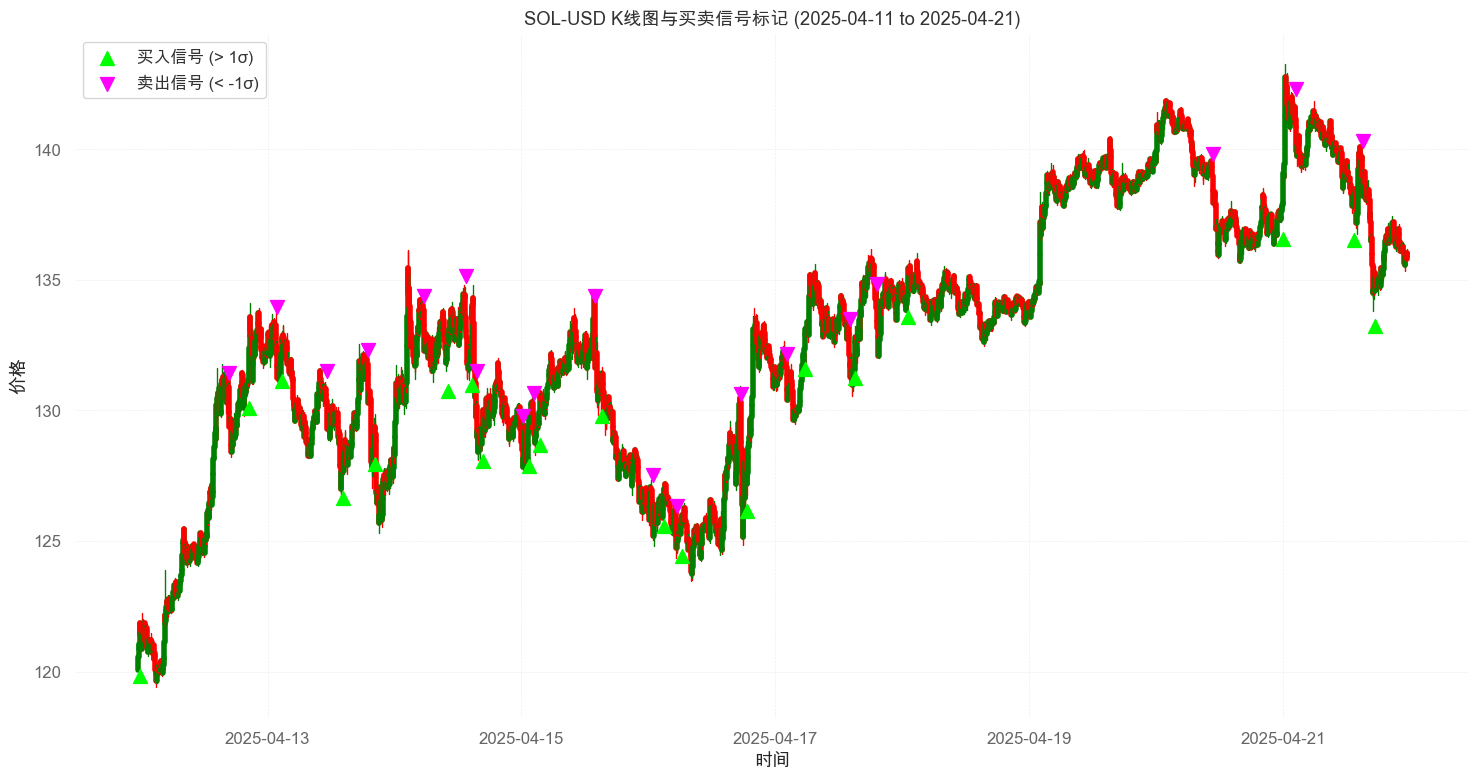

In [177]:


# 打印一下z_scores的统计信息，看看分布情况
print("\nZ-Score统计信息:")
print(f"Z-Score最大值: {z_scores.max():.4f}")
print(f"Z-Score最小值: {z_scores.min():.4f}")
print(f"Z-Score均值: {z_scores.mean():.4f}")
print(f"Z-Score标准差: {z_scores.std():.4f}")


# 5. 创建K线图
plt.figure(figsize=(15, 8))

# 确保 plot_data 包含绘图所需列
plot_kline = plot_data[['Open', 'High', 'Low', 'Close']]

# 绘制K线主体
for idx, row in plot_kline.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'
    # 绘制影线
    plt.plot([idx, idx], [row['Low'], row['High']], color=color, linewidth=1)
    # 绘制实体
    plt.plot([idx, idx], [row['Open'], row['Close']], color=color, linewidth=4)

# 标记买卖点
buy_scatter = plt.scatter([], [], 
                        color='lime', marker='^', s=100,
                        label=f'买入信号 (> {threshold}σ)')

sell_scatter = plt.scatter([], [], 
                         color='magenta', marker='v', s=100,
                         label=f'卖出信号 (< -{threshold}σ)')

# 如果有信号点，再绘制实际的信号点
if len(buy_signals) > 0:
    plt.scatter(buy_signals,
               plot_kline.loc[buy_signals, 'Low'] * 0.99,
               color='lime', marker='^', s=100, zorder=5)

if len(sell_signals) > 0:
    plt.scatter(sell_signals,
               plot_kline.loc[sell_signals, 'High'] * 1.01,
               color='magenta', marker='v', s=100, zorder=5)

# 设置图表属性
plt.title(f'SOL-USD K线图与买卖信号标记 ({start_date_plot.date()} to {end_date_plot.date()})')
plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Z-Score统计信息:
Z-Score最大值: 10.6913
Z-Score最小值: -2.6083
Z-Score均值: -0.0000
Z-Score标准差: 1.0000

信号统计:
买入信号数量: 141
卖出信号数量: 66


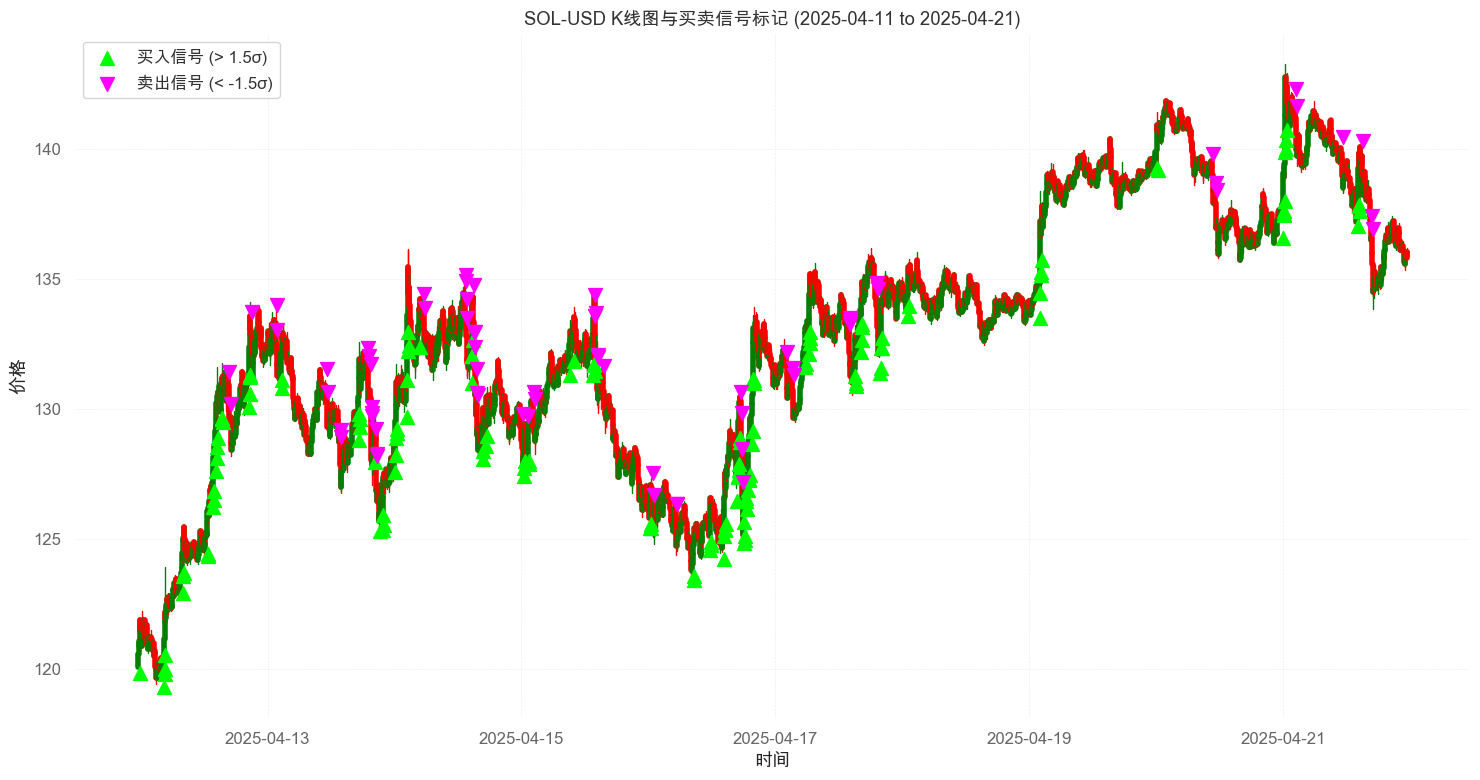

In [ ]:
# ## 4. 基于筛选后的数据重新计算买卖信号
# # 先对预测值进行标准化
# z_scores = (filtered_y_pred - filtered_y_pred.mean()) / filtered_y_pred.std()

# # 打印一下z_scores的统计信息，看看分布情况
# print("\nZ-Score统计信息:")
# print(f"Z-Score最大值: {z_scores.max():.4f}")
# print(f"Z-Score最小值: {z_scores.min():.4f}")
# print(f"Z-Score均值: {z_scores.mean():.4f}")
# print(f"Z-Score标准差: {z_scores.std():.4f}")

# # 使用较小的阈值以确保能看到信号
# threshold = 1.5  # 降低到0.5个标准差，这样可以产生更多的信号点
# sell_signals = plot_data.index[z_scores < -threshold]  # 获取卖出信号的时间点
# buy_signals = plot_data.index[z_scores > threshold]    # 获取买入信号的时间点

# # 打印信号数量
# print(f"\n信号统计:")
# print(f"买入信号数量: {len(buy_signals)}")
# print(f"卖出信号数量: {len(sell_signals)}")

# # 5. 创建K线图
# plt.figure(figsize=(15, 8))

# # 确保 plot_data 包含绘图所需列
# plot_kline = plot_data[['Open', 'High', 'Low', 'Close']]

# # 绘制K线主体
# for idx, row in plot_kline.iterrows():
#     color = 'green' if row['Close'] >= row['Open'] else 'red'
#     # 绘制影线
#     plt.plot([idx, idx], [row['Low'], row['High']], color=color, linewidth=1)
#     # 绘制实体
#     plt.plot([idx, idx], [row['Open'], row['Close']], color=color, linewidth=4)

# # 标记买卖点
# buy_scatter = plt.scatter([], [], 
#                         color='lime', marker='^', s=100,
#                         label=f'买入信号 (> {threshold}σ)')

# sell_scatter = plt.scatter([], [], 
#                          color='magenta', marker='v', s=100,
#                          label=f'卖出信号 (< -{threshold}σ)')

# # 如果有信号点，再绘制实际的信号点
# if len(buy_signals) > 0:
#     plt.scatter(buy_signals,
#                plot_kline.loc[buy_signals, 'Low'] * 0.99,
#                color='lime', marker='^', s=100, zorder=5)

# if len(sell_signals) > 0:
#     plt.scatter(sell_signals,
#                plot_kline.loc[sell_signals, 'High'] * 1.01,
#                color='magenta', marker='v', s=100, zorder=5)

# # 设置图表属性
# plt.title(f'SOL-USD K线图与买卖信号标记 ({start_date_plot.date()} to {end_date_plot.date()})')
# plt.xlabel('时间')
# plt.ylabel('价格')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()


In [178]:
#计算胜率
# 导入所需库
import vectorbt as vbt
import numpy as np
import pandas as pd

# 将信号转换为vectorbt可用的格式
entries = filtered_signals == 1  # 买入信号
exits = filtered_signals == -1   # 卖出信号

# 创建投资组合
portfolio = vbt.Portfolio.from_signals(
    close=plot_data['Close'],
    entries=entries,
    exits=exits,
    init_cash=10000,  # 初始资金
    fees=0.001,       # 手续费率
    freq='5min'       # 数据频率
)

# 计算并打印交易统计
stats = portfolio.stats()
print("\n交易统计:")
print(f"总收益率: {stats['Total Return [%]']:.2f}%")
print(f"夏普比率: {stats['Sharpe Ratio']:.2f}")
print(f"最大回撤: {stats['Max Drawdown [%]']:.2f}%")

# 获取详细的交易记录
trades = portfolio.trades
print("\n交易详情:")
print(f"总交易次数: {len(trades)}")
# print(f"盈利交易次数: {len(trades[trades['PnL'] > 0])}")
# print(f"亏损交易次数: {len(trades[trades['PnL'] < 0])}")
# print(f"胜率: {len(trades[trades['PnL'] > 0]) / len(trades) * 100:.2f}%")
# print(f"平均盈利: {trades[trades['PnL'] > 0]['PnL'].mean():.2f}")
# print(f"平均亏损: {trades[trades['PnL'] < 0]['PnL'].mean():.2f}")
# print(f"盈亏比: {abs(trades[trades['PnL'] > 0]['PnL'].mean() / trades[trades['PnL'] < 0]['PnL'].mean()):.2f}")

# 绘制权益曲线
portfolio.plot().show()


交易统计:
总收益率: -1.69%
夏普比率: -0.55
最大回撤: 15.32%

交易详情:
总交易次数: 20


In [ ]:
#持仓信号逻辑，当持仓的时候，要根据衰减信息来调整仓位
